# Notebook for data preparation and visualization

In [157]:
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from sklearn import decomposition
import csv

warnings.simplefilter('ignore')
#line to print the plots here
%matplotlib inline
#Render images
%config inlineBackend.figure_format = 'svg'
folder_Firebrowse_GBM="Data/Firebrowse_GBM/"
folder_Verhaak="Data/Verhaak_Data/"
folder_TestSet="Data/First_data_split/TestSet/"
folder_TrainingSet="Data/First_data_split/TrainingSet/"

#Display more rows and columns
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

### Data Provenance

All Data except for the RNASeq data was downloaded with RTCGAToolbox with the code TCGADownload.R that is in the Github Repository: https://github.com/CamilaDuitama/MasterThesis/blob/master/DownloadTCGA.R

RNASeq data was downloaded directly from the Firebrowse website: http://firebrowse.org/?cohort=GBM

√ Clinical Data

√ RNA Microarray Data

√ MicroArray miRNA

√ Methylation

√ Copy Number (GISTIC)

√ RNASeq

In [14]:
#Function to chop the ID of the samples in the Sample_status dataframe, because originally the ID's are longer.
def chop(x:str):
    return x[0:12]

### Clinical Data

In [2]:
clinical= pd.read_csv(folder_Firebrowse_GBM+"Clinical.csv", sep=",",header=0,index_col=0)
clinical["years_to_birth"] = clinical["years_to_birth"].apply(pd.to_numeric)
clinical["days_to_death"] = clinical["days_to_death"].apply(pd.to_numeric)
clinical["date_of_initial_pathologic_diagnosis"] = clinical["date_of_initial_pathologic_diagnosis"].apply(pd.to_numeric)
clinical["karnofsky_performance_score"] = clinical["karnofsky_performance_score"].apply(pd.to_numeric)
clinical["vital_status"] = clinical["vital_status"].apply(pd.to_numeric)
clinical=clinical.drop(columns=['Composite Element REF'])
new_index=pd.Series([w.replace(".","-").upper() for w in clinical.index.tolist()])
clinical.set_index(new_index,inplace=True)
clinical.head()

,years_to_birth,vital_status,days_to_death,days_to_last_followup,tumor_tissue_site,gender,date_of_initial_pathologic_diagnosis,radiation_therapy,karnofsky_performance_score,histological_type,race,ethnicity
TCGA-06-6391,44,1,45.0,NaN,brain,female,2011,no,NaN,untreated primary (de novo) gbm,white,not hispanic or latino
TCGA-19-A6J4,68,1,121.0,NaN,brain,male,2013,NaN,NaN,glioblastoma multiforme (gbm),black or african american,not hispanic or latino
TCGA-06-1806,47,1,466.0,NaN,brain,male,2009,yes,90.0,glioblastoma multiforme (gbm),white,not hispanic or latino
TCGA-06-5408,54,1,357.0,NaN,brain,female,2009,yes,80.0,untreated primary (de novo) gbm,white,not hispanic or latino
TCGA-06-5410,72,1,108.0,NaN,brain,female,2010,no,60.0,untreated primary (de novo) gbm,white,not hispanic or latino


In [3]:
#Karnosfky performance score : How healthy a patient is

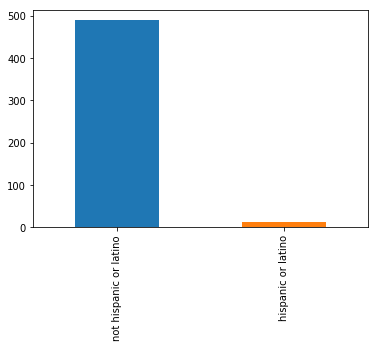

In [3]:
clinical['ethnicity'].value_counts().plot(kind='bar')

In [4]:
clinical.shape

(595, 12)

In [5]:
clinical_description=clinical.describe()
clinical_description.head(10)

,years_to_birth,vital_status,days_to_death,days_to_last_followup,date_of_initial_pathologic_diagnosis,karnofsky_performance_score
count,595.000000,595.000000,490.000000,102.000000,595.000000,442.000000
mean,57.816807,0.825210,504.500000,479.392157,2004.815126,77.036199
std,14.416311,0.380107,538.727567,540.490283,5.042524,15.621473
min,10.000000,0.000000,3.000000,0.000000,1989.000000,0.000000
25%,50.000000,1.000000,170.500000,156.250000,2002.000000,70.000000
50%,59.000000,1.000000,382.000000,261.000000,2006.000000,80.000000
75%,68.000000,1.000000,609.250000,628.000000,2009.000000,80.000000
max,89.000000,1.000000,3881.000000,2818.000000,2013.000000,100.000000


## RNA Microarray data

In [133]:
mRNAArray= pd.read_csv(folder_Firebrowse_GBM+'gdac.broadinstitute.org_GBM.Merge_transcriptome__ht_hg_u133a__broad_mit_edu__Level_3__gene_rma__data.Level_3.2016012800.0.0.csv', sep=",",header=0,index_col=0)
mRNAArray=mRNAArray.apply(pd.to_numeric)
mRNAArray=mRNAArray.transpose()
mRNAArray.index=mRNAArray.index.map(chop)
mRNAArray.head()

,AACS,FSTL1,ELMO2,CREB3L1,RPS11,PNMA1,MMP2,SAMD4A,SMARCD3,A4GNT,C9orf39,PKNOX2,RALYL,ZHX3,ERCC5,RXFP3,APBB2,BBOX1,PRO0478,GCSH,XDH,EDN1,MTERF,PDCL3,CLK4,KCNG1,CXCR4,DECR1,SALL1,PTPRR,CADM4,IRAK1,CFHR5,HNRPD,TMSB10,CXCL3,LMAN1,SUHW1,CHD8,SUMO1,GP1BA,OR7A10,DDB1,CHRNA10,STYK1,MYO9B,CCNI,MMP7,EP300,CRNKL1,C9orf45,XAB2,RTN1,HIC2,TBX10,CENPQ,UTY,OR2W1,ATP5G2,ZEB1,ZG16,ERG,PARN,SOD2,JOSD3,ADAM5P,CHD9,hCG_40738,STK16,PDE1C,SEMA4D,AGPAT1,TOB2,BANK1,MAP3K3,MAX,GRM2,OSBPL8,PROSC,NR4A2,RICS,PIR,PPCS,IPO9,LONP1,EVC,CXCL13,SCYL3,KIAA1199,SORL1,NAT10,CHD1,SYN3,DMC1,SLC22A2,SERPINF1,C20orf27,OR7A17,RPS6KA5,LHB,TAOK3,STK25,SLC12A4,BRCA1,GBL,C14orf108,CDC25B,BMP3,MAP1LC3C,TMEM180,CRYGC,SLK,POU3F1,C20orf32,USP52,HIGD1B,BAZ1B,USP6NL,SLCO2B1,ABCD4,DIMT1L,SLC25A46,LARP7,TEK,CD160,TERF2IP,PHF20,COL1A1,KIAA0090,GTPBP1,GRK5,AP1S2,RAB33B,CA11,ALDOC,NUDT1,ZNF212,ACBD3,ZNF83,PRDM2,GDPD5,PDCD4,CEP350,FOXP3,SMYD3,CST7,SELL,CIAO1,LGI2,WDR45,ANKRD6,LTBP4,PSCD3,PYY,KCNC1,SIRT6,CCL19,ARHGEF9,ABR,C10orf22,STK17A,FOXE1,GML,CNGA3,CD38,ZDHHC6,NEFH,PGBD5,CTDSP2,RMND5B,ZNF257,DUSP4,FLJ22167,EXOSC7,ROR2,FOXM1,ZBTB48,BUD31,MAOA,CCDC41,TNNT3,FBXO11,GYPC,PLIN,RFXAP,C6orf15,RNF4,F8A1,PPP1R3D,GRB2,TPM3,SYT13,EPB42,RP5-1077B9.4,EIF1,CETN3,FPGT,PRY,NTHL1,POLR2B,RPS28,GDF10,COQ9,P2RX3,GCC2,RARRES3,PLXNA1,WBP4,KIAA0100,PMF1,HS2ST1,CRELD2,C8G,CD82,PMM1,CBLL1,LIM2,VAX2,SETDB1,LRAP,GCLM,CPEB3,PPM1A,INTS1,MMP16,CAMTA1,SAMSN1,DRD3,GMPPA,C11orf73,AIPL1,PTP4A2,IL24,BDKRB1,HPCA,MLF1,SEC14L1,CHFR,EMILIN1,THADA,TAF12,NDUFS4,ID1,PIK3CB,COL18A1,PDZD3,TBC1D17,COX8A,CDCA4,C2orf44,...,PTPN3,C11orf51,ZBED2,NPY2R,SCAMP2,SYT17,PLD3,ART3,SGSM2,OR1A2,SLC5A1,MLNR,EPHB6,POFUT1,C6orf25,STAC,CXXC4,TJP2,JARID1C,LILRA3,KRT10,SERINC1,CCT5,ARF3,RAB27A,SLC9A8,PEX19,CNP,EDN2,PSMD7,UQCR,CCDC121,SSX2IP,PPP1R3C,TM2D1,LRP4,TTC17,C4BPB,POMT2,ARL15,ZNF253,CHRNA9,SOX11,HIVEP3,SEP15,MRPL16,PKD2L1,RHBDD3,BMPR1B,PDE8B,ABLIM3,CENPC1,C2orf42,LTC4S,PSMC3,SMARCA2,FUT5,P4HB,ADH6,CST2,PLAC4,BRF2,RAMP2,BCL11A,F11R,CLUAP1,ZNF330,PSMB1,VIPR1,TXN,ACTA2,KIAA0947,REM1,FANCE,PLAC8,BECN1,GMPS,LGALS8,ANKRD1,DDR1,ATP6V1D,PTGS1,ALDOB,DCC,SPAG7,HOXD9,LOC440295,SYNPO,C6orf47,UBE3C,TRIT1,HOXC6,LRP2BP,PDSS2,MYST2,GABARAPL3,ARAF,PLA2G2E,KLF10,DCTN5,ASCL1,TSNAXIP1,HKDC1,PHF10,FAM131B,PSME3,IFNA10,NUP43,DBR1,NME3,CYP46A1,L1TD1,NMD3,CHN1,HGSNAT,RAG2,KIAA0754,TMED1,PMM2,VPS13C,METTL3,REXO2,SLC14A1,ANXA4,CA1,UAP1,KCNJ15,DHODH,TULP3,RPS14,ATP2A2,APBB1IP,ATIC,ONECUT2,ADAM15,FAM110B,NPL,LGR4,STRN,UEVLD,GAB1,SULT1B1,SNAI2,ZGPAT,KCNN4,SNF1LK,DLEU1,UBE2Q1,ZMYM6,JPH3,HEATR3,CYP2J2,FAM119B,FAM38A,APOL3,FLNA,YY2,IL2RB,SLCO4C1,DENND2D,KIAA0152,BAX,CP,LRPAP1,G6PC3,RPL37,NCOA4,LRRC14,GORASP1,FKBP1A,FXYD3,CYP24A1,SMARCAL1,NDUFS7,ABCB8,CCDC44,PRMT7,ZNF562,COQ2,USH1C,SRF,MAT2A,PGPEP1,TRPC3,SEMA4C,SIN3B,KLRD1,UTX,TRIM8,NDRG3,SLC10A3,SEMA3C,RNF6,GRAMD3,VAV1,PDGFC,CACNA1I,PEPD,S100A13,ARMCX2,TP63,ANXA11,CSF2RB,ZNF358,IFI44,DAZ4,EIF2C4,RPS6KA3,PHF21A,FAM49B,DACT1,ATP5G1,PPWD1,PNPLA2,DNAJC13,PAH,PTCH2,EAF2,ERCC2,TRMU,USP3,C14orf101,CCDC9,VPS13B,DCLRE1C,ST18,FRMD4B,PSMB9,RFPL1,LOC552889,CDC2L2,ProSAPiP1,ADRBK2,HCLS1,GPR15,CSF2,SLC2A11,GRIP2,MMP9,GPLD1,KIAA0802,DHRS2,RAB8A,SGEF,PIK3IP1,RPS27,SNRPD2,SLC39A6,CTSC,AQP7
TCGA-02-0001,6.500551,8.729663,5.511362,4.882953,10.984784,7.535193,8.674010,5.032552,4.710970,5.108478,4.788851,5.031860,4.354023,5.057832,6.938835,3.923728,4.968457,3.788748,3.899047,8.133074,4.583046,5.713743,6.320967,6.208020,6.104118,4.529051,7.861765,8.659940,4.674090,4.235680,4.395482,9.145942,4.147892,8.694796,13.174292,4.912342,4.603610,4.607337,7.034972,7.626174,4.648582,4.835915,7.965280,4.685791,5.943736,5.272516,10.186255,5.399321,6.373266,5.125710,4.378752,5.202034,5.334359,4.861035,4.336362,4.588574,4.300481,3.544995,10.813180,4.735778,4.383486,4.479868,7.531977,8.742529,7.911021,4.219728,6.129397,4.491577,5.436920,4.936893,6.990564,6.749265,6.335168,4.687241,6.416764,5.918338,4.813085,7.583604,5.470831,5.988463,5.496485,6.536004,9.139820,6.781858,7.956309,4.537492,8.743723,5.713169,6.072905,6.291494,7.148647,5.637882,4.578269,5.039334

In [7]:
mRNA_description=mRNAArray.describe()
mRNA_description.head(8)

,AACS,FSTL1,ELMO2,CREB3L1,RPS11,PNMA1,MMP2,SAMD4A,SMARCD3,A4GNT,C9orf39,PKNOX2,RALYL,ZHX3,ERCC5,RXFP3,APBB2,BBOX1,PRO0478,GCSH,XDH,EDN1,MTERF,PDCL3,CLK4,KCNG1,CXCR4,DECR1,SALL1,PTPRR,CADM4,IRAK1,CFHR5,HNRPD,TMSB10,CXCL3,LMAN1,SUHW1,CHD8,SUMO1,GP1BA,OR7A10,DDB1,CHRNA10,STYK1,MYO9B,CCNI,MMP7,EP300,CRNKL1,C9orf45,XAB2,RTN1,HIC2,TBX10,CENPQ,UTY,OR2W1,ATP5G2,ZEB1,ZG16,ERG,PARN,SOD2,JOSD3,ADAM5P,CHD9,hCG_40738,STK16,PDE1C,SEMA4D,AGPAT1,TOB2,BANK1,MAP3K3,MAX,GRM2,OSBPL8,PROSC,NR4A2,RICS,PIR,PPCS,IPO9,LONP1,EVC,CXCL13,SCYL3,KIAA1199,SORL1,NAT10,CHD1,SYN3,DMC1,SLC22A2,SERPINF1,C20orf27,OR7A17,RPS6KA5,LHB,TAOK3,STK25,SLC12A4,BRCA1,GBL,C14orf108,CDC25B,BMP3,MAP1LC3C,TMEM180,CRYGC,SLK,POU3F1,C20orf32,USP52,HIGD1B,BAZ1B,USP6NL,SLCO2B1,ABCD4,DIMT1L,SLC25A46,LARP7,TEK,CD160,TERF2IP,PHF20,COL1A1,KIAA0090,GTPBP1,GRK5,AP1S2,RAB33B,CA11,ALDOC,NUDT1,ZNF212,ACBD3,ZNF83,PRDM2,GDPD5,PDCD4,CEP350,FOXP3,SMYD3,CST7,SELL,CIAO1,LGI2,WDR45,ANKRD6,LTBP4,PSCD3,PYY,KCNC1,SIRT6,CCL19,ARHGEF9,ABR,C10orf22,STK17A,FOXE1,GML,CNGA3,CD38,ZDHHC6,NEFH,PGBD5,CTDSP2,RMND5B,ZNF257,DUSP4,FLJ22167,EXOSC7,ROR2,FOXM1,ZBTB48,BUD31,MAOA,CCDC41,TNNT3,FBXO11,GYPC,PLIN,RFXAP,C6orf15,RNF4,F8A1,PPP1R3D,GRB2,TPM3,SYT13,EPB42,RP5-1077B9.4,EIF1,CETN3,FPGT,PRY,NTHL1,POLR2B,RPS28,GDF10,COQ9,P2RX3,GCC2,RARRES3,PLXNA1,WBP4,KIAA0100,PMF1,HS2ST1,CRELD2,C8G,CD82,PMM1,CBLL1,LIM2,VAX2,SETDB1,LRAP,GCLM,CPEB3,PPM1A,INTS1,MMP16,CAMTA1,SAMSN1,DRD3,GMPPA,C11orf73,AIPL1,PTP4A2,IL24,BDKRB1,HPCA,MLF1,SEC14L1,CHFR,EMILIN1,THADA,TAF12,NDUFS4,ID1,PIK3CB,COL18A1,PDZD3,TBC1D17,COX8A,CDCA4,C2orf44,...,PTPN3,C11orf51,ZBED2,NPY2R,SCAMP2,SYT17,PLD3,ART3,SGSM2,OR1A2,SLC5A1,MLNR,EPHB6,POFUT1,C6orf25,STAC,CXXC4,TJP2,JARID1C,LILRA3,KRT10,SERINC1,CCT5,ARF3,RAB27A,SLC9A8,PEX19,CNP,EDN2,PSMD7,UQCR,CCDC121,SSX2IP,PPP1R3C,TM2D1,LRP4,TTC17,C4BPB,POMT2,ARL15,ZNF253,CHRNA9,SOX11,HIVEP3,SEP15,MRPL16,PKD2L1,RHBDD3,BMPR1B,PDE8B,ABLIM3,CENPC1,C2orf42,LTC4S,PSMC3,SMARCA2,FUT5,P4HB,ADH6,CST2,PLAC4,BRF2,RAMP2,BCL11A,F11R,CLUAP1,ZNF330,PSMB1,VIPR1,TXN,ACTA2,KIAA0947,REM1,FANCE,PLAC8,BECN1,GMPS,LGALS8,ANKRD1,DDR1,ATP6V1D,PTGS1,ALDOB,DCC,SPAG7,HOXD9,LOC440295,SYNPO,C6orf47,UBE3C,TRIT1,HOXC6,LRP2BP,PDSS2,MYST2,GABARAPL3,ARAF,PLA2G2E,KLF10,DCTN5,ASCL1,TSNAXIP1,HKDC1,PHF10,FAM131B,PSME3,IFNA10,NUP43,DBR1,NME3,CYP46A1,L1TD1,NMD3,CHN1,HGSNAT,RAG2,KIAA0754,TMED1,PMM2,VPS13C,METTL3,REXO2,SLC14A1,ANXA4,CA1,UAP1,KCNJ15,DHODH,TULP3,RPS14,ATP2A2,APBB1IP,ATIC,ONECUT2,ADAM15,FAM110B,NPL,LGR4,STRN,UEVLD,GAB1,SULT1B1,SNAI2,ZGPAT,KCNN4,SNF1LK,DLEU1,UBE2Q1,ZMYM6,JPH3,HEATR3,CYP2J2,FAM119B,FAM38A,APOL3,FLNA,YY2,IL2RB,SLCO4C1,DENND2D,KIAA0152,BAX,CP,LRPAP1,G6PC3,RPL37,NCOA4,LRRC14,GORASP1,FKBP1A,FXYD3,CYP24A1,SMARCAL1,NDUFS7,ABCB8,CCDC44,PRMT7,ZNF562,COQ2,USH1C,SRF,MAT2A,PGPEP1,TRPC3,SEMA4C,SIN3B,KLRD1,UTX,TRIM8,NDRG3,SLC10A3,SEMA3C,RNF6,GRAMD3,VAV1,PDGFC,CACNA1I,PEPD,S100A13,ARMCX2,TP63,ANXA11,CSF2RB,ZNF358,IFI44,DAZ4,EIF2C4,RPS6KA3,PHF21A,FAM49B,DACT1,ATP5G1,PPWD1,PNPLA2,DNAJC13,PAH,PTCH2,EAF2,ERCC2,TRMU,USP3,C14orf101,CCDC9,VPS13B,DCLRE1C,ST18,FRMD4B,PSMB9,RFPL1,LOC552889,CDC2L2,ProSAPiP1,ADRBK2,HCLS1,GPR15,CSF2,SLC2A11,GRIP2,MMP9,GPLD1,KIAA0802,DHRS2,RAB8A,SGEF,PIK3IP1,RPS27,SNRPD2,SLC39A6,CTSC,AQP7
count,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,538.000000,538.00000

In [8]:
mRNAArray.shape

(538, 12042)

In [9]:
def hist_col(label:str,df:pd.core.frame.DataFrame, description:pd.core.frame.DataFrame):
    """
    Function to plot the histogram of a column in a dataframe with its corresponding description

    Arguments:

    label: String that corresponds to the name of the column being analysed
    df: Dataframe that contains the column label
    description: Dataframe that comes as the output of df.describe()
    """
    # the histogram of the data
    mu=description.loc["mean",label]
    sigma=description.loc["std",label]
    num_bins = "auto"

    n, bins, patches = plt.hist(df[label], num_bins, normed=1, facecolor='blue', alpha=0.5)

    # add a 'best fit' line

    y = mlab.normpdf(bins, mu, sigma)
    plt.plot(bins, y, 'r--')
    plt.title(r'Histogram of '+label+' : $\mu='+str(mu)+'$, $\sigma='+str(sigma)+'$')

    # Tweak spacing to prevent clipping of ylabel
    plt.subplots_adjust(left=0.15)
    plt.show()
    return


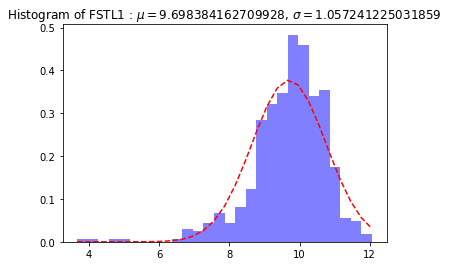

In [10]:
hist_col("FSTL1",mRNAArray,mRNA_description)

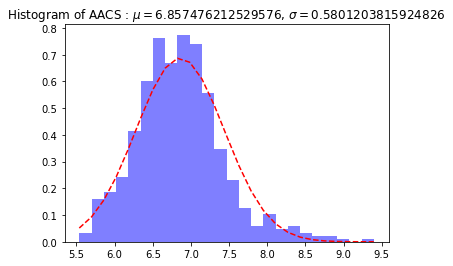

In [11]:
hist_col("AACS",mRNAArray,mRNA_description)

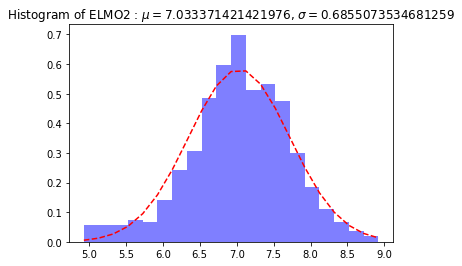

In [12]:
hist_col("ELMO2",mRNAArray,mRNA_description)

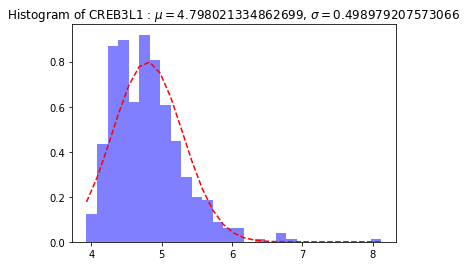

In [13]:
hist_col("CREB3L1",mRNAArray,mRNA_description)

## Comparison with Verhaak Gene Signature and Verhaak Sample

Note: Sample_satus data comes from this link: 

https://tcga-data.nci.nih.gov/docs/publications/gbm_exp/TCGA_unified_CORE_ClaNC840.txt

Which has the expression values and subtype calls for the Core TCGA samples using the unified scaled data

In [15]:
Sample_status=pd.read_csv(folder_Verhaak+'Sample_status.csv', sep=";", index_col=0)
Sample_status=Sample_status.transpose()
Sample_status=pd.DataFrame(Sample_status["Subtype"])
Sample_status=Sample_status.drop("Genes highly expressed in each subtype used for Gene Ontology",axis=0)
Sample_status.index=Sample_status.index.map(chop)
Sample_status.head()

,Subtype
TCGA-02-0003,Proneural
TCGA-02-0010,Proneural
TCGA-02-0011,Proneural
TCGA-02-0014,Proneural
TCGA-02-0024,Proneural


In [90]:
Sample_status=Sample_status.merge(clinical[["vital_status","days_to_death"]],how="left",left_index=True,right_index=True)
Sample_status.head()

,Subtype,vital_status,days_to_death
TCGA-02-0003,Proneural,1,144.0
TCGA-02-0010,Proneural,1,1077.0
TCGA-02-0011,Proneural,1,630.0
TCGA-02-0014,Proneural,1,2512.0
TCGA-02-0024,Proneural,1,1615.0


In [91]:
Sample_status.shape

(173, 3)

In [25]:
Verhaak_GS=pd.read_csv(folder_Verhaak+'Verhaak_gene_signature.csv', sep=";",header=0,index_col=0)
Verhaak_GS=pd.DataFrame(Verhaak_GS.index.tolist())
Verhaak_GS.columns=["Gene Symbol"]
Verhaak_GS.head()

,Gene Symbol
0,CDKN1B
1,EPB41
2,CLGN
3,PDE10A
4,RALGPS2


In [26]:
#How many genes of the Verhaak signature are in the mRNAArray dataset?

In [27]:
if(set(Verhaak_GS["Gene Symbol"].values).issubset(set(mRNAArray.columns))): 
    print("All genes in the Verhaak signature are in the mRNAArray dataset")

All genes in the Verhaak signature are in the mRNAArray dataset


In [30]:
#How many patients in the mRNAArray dataset are also Verhaak samples?

In [31]:
def check(df1: pd.DataFrame, df2: pd.DataFrame):
    """
    Function to check if the ids in one dataframe are also on the other dataframe  Arguments:
    df1= Larger dataframe
    df2= Smaller dataframe
    """
    
    d=dict()
    for x in df1.index.tolist():
        d[x]=list() 
    for i in df1.index.tolist():
        for j in df2.index.tolist():
            if i in j:
                d[i]=j
    return d

In [32]:
d=check(Sample_status,mRNAArray)
d

{'TCGA-02-0003': 'TCGA-02-0003-01A-01R-0177-01',
 'TCGA-02-0004': 'TCGA-02-0004-01A-01R-0298-01',
 'TCGA-02-0006': [],
 'TCGA-02-0007': 'TCGA-02-0007-01A-01R-0177-01',
 'TCGA-02-0009': 'TCGA-02-0009-01A-01R-0177-01',
 'TCGA-02-0010': 'TCGA-02-0010-01A-01R-0177-01',
 'TCGA-02-0011': 'TCGA-02-0011-01B-01R-0177-01',
 'TCGA-02-0014': 'TCGA-02-0014-01A-01R-0177-01',
 'TCGA-02-0016': 'TCGA-02-0016-01A-01R-0298-01',
 'TCGA-02-0021': 'TCGA-02-0021-01A-01R-0177-01',
 'TCGA-02-0023': 'TCGA-02-0023-01B-01R-0298-01',
 'TCGA-02-0024': 'TCGA-02-0024-01B-01R-0177-01',
 'TCGA-02-0025': 'TCGA-02-0025-01A-01R-0298-01',
 'TCGA-02-0026': 'TCGA-02-0026-01B-01R-0298-01',
 'TCGA-02-0027': 'TCGA-02-0027-01A-01R-0177-01',
 'TCGA-02-0028': 'TCGA-02-0028-01A-01R-0177-01',
 'TCGA-02-0033': 'TCGA-02-0033-01A-01R-0177-01',
 'TCGA-02-0034': 'TCGA-02-0034-01A-01R-0177-01',
 'TCGA-02-0038': 'TCGA-02-0038-01A-01R-0177-01',
 'TCGA-02-0039': 'TCGA-02-0039-01A-01R-0298-01',
 'TCGA-02-0043': 'TCGA-02-0043-01A-01R-0177-01',

In [37]:
result=0
for each in d.keys():
    if len(d[each])==0:
        print(each)
        result=result+1
print(str(result)+" patients in the Verhaak sample aren't in the mRNAArray dataset")

TCGA-02-0006
TCGA-02-0055
2 patients in the Verhaak sample aren't in the mRNAArray dataset


From here on I had to find the equivalence between the patient IDs used by Verhaak and the ones on the Firebrowse TCGA data set

In [38]:
Verhaak_id=list()
Firebrowse_id=list()
for each in d.keys():
    if len(d[each])>0:
        Verhaak_id.append(each)
        Firebrowse_id.append(d[each])
    else:
        Verhaak_id.append(each)
        Firebrowse_id.append(None)
dummie=pd.DataFrame()
dummie["CLID"]=Verhaak_id
dummie["Hybridization REF"]=Firebrowse_id
dummie.head()

,CLID,Hybridization REF
0,TCGA-02-0003,TCGA-02-0003-01A-01R-0177-01
1,TCGA-02-0010,TCGA-02-0010-01A-01R-0177-01
2,TCGA-02-0011,TCGA-02-0011-01B-01R-0177-01
3,TCGA-02-0014,TCGA-02-0014-01A-01R-0177-01
4,TCGA-02-0024,TCGA-02-0024-01B-01R-0177-01


In [50]:
labels=dummie.merge(Sample_status, how="left", left_on="CLID",right_index=True)
labels.head()

,CLID,Hybridization REF,Subtype
0,TCGA-02-0003,TCGA-02-0003-01A-01R-0177-01,Proneural
1,TCGA-02-0010,TCGA-02-0010-01A-01R-0177-01,Proneural
2,TCGA-02-0011,TCGA-02-0011-01B-01R-0177-01,Proneural
3,TCGA-02-0014,TCGA-02-0014-01A-01R-0177-01,Proneural
4,TCGA-02-0024,TCGA-02-0024-01B-01R-0177-01,Proneural


In [40]:
#Code to mark the samples in mRNAArray as one of the four subclasses of GBM or as other, and assign a color to them
result=list()
for i in mRNAArray.index.tolist():
    if i in labels["Hybridization REF"].tolist():
        index=labels["Hybridization REF"].tolist().index(i)
        result.append(labels.loc[index,"Subtype"])
    else:
        result.append("Other")
result=pd.DataFrame(result,columns=["target"])
result.head(20)

,target
0,Other
1,Proneural
2,Mesenchymal
3,Classical
4,Classical
5,Proneural
6,Proneural
7,Proneural
8,Other
9,Classical


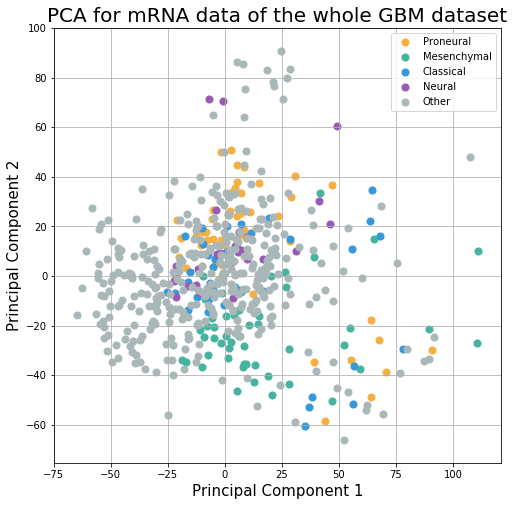

In [41]:
pca = decomposition.PCA(n_components=2)
PC = pca.fit_transform(mRNAArray.values)
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
targets=["Proneural","Mesenchymal","Classical","Neural","Other"]
colors = ["#F5B041", '#45B39D', '#3498DB',"#9B59B6","#AAB7B8"]
ax.set_title('PCA for mRNA data of the whole GBM dataset', fontsize = 20)
for target,color in zip(targets,colors):
    indicesToKeep = result['target'] == target
    ax.scatter(PC[indicesToKeep,0]
               , PC[indicesToKeep,1]
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()   


#### PCA with the Verhaak signature and samples only

In [42]:
col=Veerhak_GS["Gene Symbol"].tolist()
ind=[x for x in d.values() if x!=[]]

In [43]:
Verhaak=mRNAArray.loc[ind,col]
Verhaak_description=Verhaak.describe()
Verhaak_description.head(10)

,CDKN1B,EPB41,CLGN,PDE10A,RALGPS2,TAF5,ACTR1A,PELI1,ZNF804A,PPM1D,RAD21,SORCS3,ALCAM,PURG,SLC1A1,NR0B1,FBXO21,GADD45G,GABRA3,FHOD3,TMSL8,LRRTM4,PAFAH1B3,FAM110B,REEP1,SNX26,LRP6,C1QL1,TMCC1,GSK3B,MMP16,LPHN3,DLL3,SEC61A2,ICK,RAP2A,ZNF286A,FAM125B,ZEB2,AMOTL2,NKX2-2,TTC3,TOP2B,SCN3A,TOX3,MLLT11,RALGPS1,GSTA4,DGKI,MTSS1,SATB1,KIF21B,PODXL2,CRMP1,GNG4,MYT1,BCL7A,CHD7,SOX4,SOX11,DCX,C6orf134,FAM77C,MARCKSL1,C1orf106,DBN1,DPYSL4,TMEFF1,STMN4,DUSP26,PAK7,PAK3,MAST1,TNRC4,CDK5R1,ATP1A3,FGF9,WASF1,CA10,RP11-35N6.1,SOX10,ERBB3,RAB33A,IL1RAPL1,DNM3,GPR17,CLASP2,PPM1E,STMN1,FLRT1,EPHB1,HDAC2,PHF16,LOC81691,CDC7,MYB,MCM10,ATAD5,HMGB3,CDC25A,TOPBP1,HN1,AOF2,SLCO5A1,NOL4,YPEL1,CXXC4,ZNF643,KLRK1,KLRC4,KLRC3,PCDH11Y,PCDH11X,HRASLS,KIAA1166,ZNF184,CASK,ZNF711,ZNF510,WDR68,MYST2,CBX1,CAMSAP1L1,HOXD3,MATR3,TMEM118,LOC55565,VAX2,TMEM35,NRXN1,SPTBN2,NCALD,SOX2,SCG3,TTYH1,C1orf61,GPM6A,DPF1,RUFY3,NRXN2,NCAM1,MAPT,SRGAP3,FXYD6,ABAT,PHLPP,OLIG2,MAP2,BCAN,NLGN3,CSPG5,DPP6,MYO10,BAI3,ASCL1,SEZ6L,CKB,CRB1,GRIA2,ARHGEF9,VEZF1,MMP15,MARCKS,BEX1,CNTN1,E2F3,RBPJ,BCOR,P2RX7,C20orf42,CSNK1E,ZNF248,PLCB4,PFN2,GPR23,GRID2,MPPED2,TSPAN3,TTPA,SIRT5,CASQ1,AKR7A3,MRPL49,GUK1,VSX1,NDRG2,PPP2R5A,RND1,ZNF323,LYRM1,SEPW1,USP33,ANKRD46,SPAST,PRPSAP2,PDE6D,ORC4L,SCHIP1,NSL1,CRBN,CRYZL1,ACYP2,MGST3,PEX19,MDH1,ATP5L,TSNAX,MAT2B,YPEL5,TCEAL1,CALM2,ATP5F1,COX5B,PEX11B,IMPA1,TTC1,GABARAPL2,NDUFS3,FBXO3,CCDC121,CRYL1,SNX11,GABRB2,SERPINI1,KCNK1,SNCG,CPNE6,KCNJ3,GRM1,VIP,HPCAL4,HPCA,CRYM,CCK,GPR22,CHN1,CA4,ADD3,CAMK2G,NTSR2,AGXT2L1,EDG1,MYBPC1,PPP1R1A,FEZF2,LOC201229,SLCO1A2,DHRS9,FLJ22655,THTPA,...,MEGF8,CD3EAP,PRKD2,IRF3,B3GALT1,CDH2,NOS2A,FBXO17,MAB21L1,CDH6,SEPT11,KLHL4,EXTL3,KLHDC8A,SMO,GLI2,RFX2,GNAS,ZFHX4,LRP5,KLHL25,RGS12,CLIP2,POMT2,SARS2,TLE2,VPS16,JUND,MYO5C,TGFB3,ILK,SNTA1,GJA1,NDP,UAP1,YAP1,LTBP1,SYPL1,RABGAP1L,ALDH3B1,LOX,FHL2,IGFBP6,DCBLD2,BNC2,CASP8,HEXA,COL8A2,TES,AIM1,ENG,FXYD5,LY75,PLAU,SH2B3,CDCP1,TRIM38,SP100,FES,S100A4,P4HA2,COL5A1,COL1A2,COL1A1,THBS1,IL1R1,LAMB1,LTBP2,RAB27A,HEXB,TMBIM1,COPZ2,ANXA4,PGCP,SRPX2,ZNF217,DRAM,MRC2,WWTR1,SERPINE1,CLCF1,LRRFIP1,FURIN,RBMS1,NRP1,MYH9,ADAM12,MVP,FER1L3,IQGAP1,CAST,SHC1,ITGA5,FNDC3B,GLT25D1,TCIRG1,TGOLN2,TNFRSF1A,ANXA1,PTRF,EHD2,EFEMP2,TIMP1,LGALS1,LGALS3,CHI3L1,CLIC1,CCDC109B,EMP3,ANXA2,PDPN,PYGL,ARSJ,SWAP70,TRADD,PLS3,ICAM3,VAMP5,RRAS,PROCR,RAB32,ASL,RELB,TGFBI,SLC16A3,IL15RA,ELF4,SLC10A3,GCNT1,LYPLA3,DSC2,MAPK13,HK3,MAN2B1,GRN,CEBPB,MGAT1,FLJ20273,POLD4,VDR,NOD2,DAB2,PTGER4,THBD,PLAUR,CASP5,CASP4,CASP1,SLAMF8,FLJ22662,RHOG,CTSB,CTSC,TGFBR2,IL4R,LHFPL2,GNA15,TNFRSF1B,CCR5,DOK3,BATF,RAC2,NCF2,KYNU,DSE,C1orf38,ITGAM,MS4A4A,MSR1,IFI30,NCF4,CD14,SIGLEC9,PTPN6,MYO1F,LAIR1,LAPTM5,ITGB2,TLR2,PTPRC,ALOX5,LCP1,FCGR2A,CD4,LCP2,CSTA,SERPINA1,PSCD4,MAFB,SYNGR2,STXBP2,ARPC1B,SIGLEC7,LILRB3,NPC2,TRPM2,FMNL1,LY96,SLC11A1,ECGF1,MFSD1,SQRDL,PSCDBP,S100A11,TNFAIP8,FPRL2,C5AR1,LILRB2,AMPD3,STAB1,MAN1A1,CTSZ,STAT6,FCGR2B,ST14,ACSL1,SCPEP1,ACPP,RAB11FIP1,TNFRSF11A,WIPF1,TNFAIP3,PTPN22,SAT1,PLK3,SEC24D,CLEC2B,MAN2A1,BDKRB2,CD2AP,SFT2D2,RUNX2,ITGA4,HFE,FHOD1,TRIM22,PHF11,RBKS,MGST2,C1orf54,BLVRB,CYBRD1,ARHGAP29,CNN2,TLR4,PIGP,UCP2,FOLR2,TEC,S100A13
count,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.00

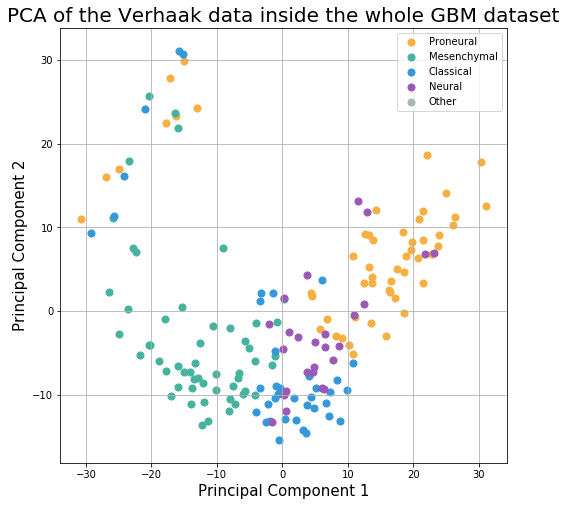

In [44]:
#Code to mark the samples in mRNAArray as one of the four subclasses of GBM or as other
result=list()
for i in Verhaak.index.tolist():
    if i in labels["Hybridization REF"].tolist():
        index=labels["Hybridization REF"].tolist().index(i)
        result.append(labels.loc[index,"Subtype"])
    else:
        result.append("Other")
result=pd.DataFrame(result,columns=["target"])
result.head()

#Code to build the PCA plot
pca = decomposition.PCA(n_components=2)
PC = pca.fit_transform(Verhaak.values)
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
targets=["Proneural","Mesenchymal","Classical","Neural","Other"]
colors = ["#F5B041", '#45B39D', '#3498DB',"#9B59B6","#AAB7B8"]
ax.set_title('PCA of the Verhaak data inside the whole GBM dataset', fontsize = 20)
for target,color in zip(targets,colors):
    indicesToKeep = result['target'] == target
    ax.scatter(PC[indicesToKeep,0]
               , PC[indicesToKeep,1]
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()   


In [45]:
_series=pd.Series(data=result["target"].values,index=Verhaak.index)

In [46]:
#The function getDiffExpressedGenes which is used to build the heatmap described in :
#https://bioconductor.org/packages/release/bioc/vignettes/RTCGAToolbox/inst/doc/RTCGAToolbox-vignette.html#reproducing-brca-results-from-original-manuscript
# Needs a control sample (i guess the positive and negative values come from a logFC)


#### Vital status

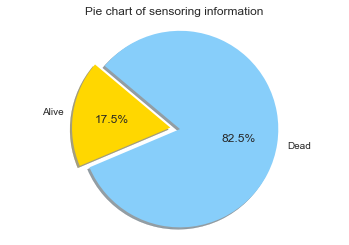

In [48]:
vital_status=clinical["vital_status"].apply(int)
ones=vital_status.sum()
zeroes=len(vital_status)-ones
# Data to plot
labels = 'Alive', 'Dead'
sizes = [zeroes,ones]
colors = ['gold', 'lightskyblue']
explode = (0.1, 0)  # explode 1st slice
 
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)
plt.title("Pie chart of sensoring information")
plt.axis('equal')
plt.show()

In [51]:
#Code to mark the samples in mRNAArray as one of the four subclasses of GBM or as other, and assign a color to them
result=list()
for i in clinical.index.tolist():
    if i in labels["CLID"].tolist():
        index=labels["CLID"].tolist().index(i)
        result.append(labels.loc[index,"Subtype"])
    else:
        result.append("Other")
result=pd.DataFrame(result,columns=["target"])
result.head()

,target
0,Other
1,Other
2,Other
3,Other
4,Other


Text(0.5, 1.0, 'Histogram of Tumour subtypes in Clinical Data for Firebrowse GBM')

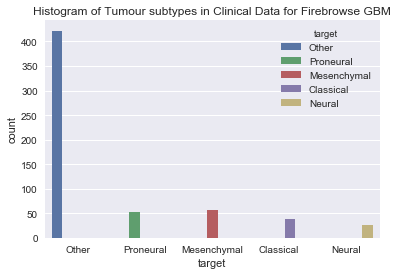

In [52]:
ax = sns.countplot(x="target", data=result,hue="target")
ax.set_title("Histogram of Tumour subtypes in Clinical Data for Firebrowse GBM")

## MicroArray miRNA

Quote from the https://confluence.broadinstitute.org/download/attachments/29790363/nature10166-s1.pdf?version=1&modificationDate=1335477590000 paper that describes how the pipeline to obtain this data:

"Data Processing

Data was quantile normalized on the probe level. Signals from probes measuring the same
microRNA are summed up to generate gene‐centric total gene signal, followed by log2
transformation. Distance Weighted Discrimination (DWD) method is applied to data for batch‐ 
correction."

In [128]:
miRNA= pd.read_csv(folder_Firebrowse_GBM+'gdac.broadinstitute.org_GBM.Merge_mirna__h_mirna_8x15k__unc_edu__Level_3__unc_DWD_Batch_adjusted__data.Level_3.2016012800.0.0.csv', sep=",",header=0,index_col=0)
miRNA=miRNA.apply(pd.to_numeric)
miRNA=miRNA.transpose()
miRNA.index=miRNA.index.map(chop)
miRNA.head()

,ebv-miR-BART1-3p,ebv-miR-BART1-5p,ebv-miR-BART10,ebv-miR-BART11-3p,ebv-miR-BART11-5p,ebv-miR-BART12,ebv-miR-BART13,ebv-miR-BART14-3p,ebv-miR-BART14-5p,ebv-miR-BART15,ebv-miR-BART16,ebv-miR-BART17-3p,ebv-miR-BART17-5p,ebv-miR-BART18,ebv-miR-BART19,ebv-miR-BART2,ebv-miR-BART20-3p,ebv-miR-BART20-5p,ebv-miR-BART3-3p,ebv-miR-BART3-5p,ebv-miR-BART4,ebv-miR-BART5,ebv-miR-BART6-3p,ebv-miR-BART6-5p,ebv-miR-BART7,ebv-miR-BART8-3p,ebv-miR-BART8-5p,ebv-miR-BART9,ebv-miR-BHRF1-1,ebv-miR-BHRF1-2,ebv-miR-BHRF1-2*,ebv-miR-BHRF1-3,hcmv-miR-UL112,hcmv-miR-UL148D,hcmv-miR-UL22A,hcmv-miR-UL22A*,hcmv-miR-UL36,hcmv-miR-UL70-3p,hcmv-miR-UL70-5p,hcmv-miR-US25-1,hcmv-miR-US25-2-3p,hcmv-miR-US25-2-5p,hcmv-miR-US33,hcmv-miR-US4,hcmv-miR-US5-1,hcmv-miR-US5-2,hsa-let-7a,hsa-let-7b,hsa-let-7c,hsa-let-7d,hsa-let-7e,hsa-let-7f,hsa-let-7g,hsa-let-7i,hsa-miR-1,hsa-miR-100,hsa-miR-101,hsa-miR-103,hsa-miR-105,hsa-miR-106a,hsa-miR-106b,hsa-miR-107,hsa-miR-10a,hsa-miR-10b,hsa-miR-122a,hsa-miR-124a,hsa-miR-125a,hsa-miR-125b,hsa-miR-126,hsa-miR-126*,hsa-miR-127,hsa-miR-128a,hsa-miR-128b,hsa-miR-129,hsa-miR-130a,hsa-miR-130b,hsa-miR-132,hsa-miR-133a,hsa-miR-133b,hsa-miR-134,hsa-miR-135a,hsa-miR-135b,hsa-miR-136,hsa-miR-137,hsa-miR-138,hsa-miR-139,hsa-miR-140,hsa-miR-141,hsa-miR-142-3p,hsa-miR-142-5p,hsa-miR-143,hsa-miR-144,hsa-miR-145,hsa-miR-146a,hsa-miR-146b,hsa-miR-147,hsa-miR-148a,hsa-miR-148b,hsa-miR-149,hsa-miR-150,hsa-miR-151,hsa-miR-152,hsa-miR-153,hsa-miR-154,hsa-miR-154*,hsa-miR-155,hsa-miR-15a,hsa-miR-15b,hsa-miR-16,hsa-miR-17-3p,hsa-miR-17-5p,hsa-miR-181a,hsa-miR-181a*,hsa-miR-181b,hsa-miR-181c,hsa-miR-181d,hsa-miR-182,hsa-miR-182*,hsa-miR-183,hsa-miR-184,hsa-miR-185,hsa-miR-186,hsa-miR-187,hsa-miR-188,hsa-miR-189,hsa-miR-18a,hsa-miR-18a*,hsa-miR-18b,hsa-miR-190,hsa-miR-191,hsa-miR-191*,hsa-miR-192,hsa-miR-193a,hsa-miR-193b,hsa-miR-194,hsa-miR-195,hsa-miR-196a,hsa-miR-196b,hsa-miR-197,hsa-miR-198,hsa-miR-199a,hsa-miR-199a*,hsa-miR-199b,hsa-miR-19a,hsa-miR-19b,hsa-miR-200a,hsa-miR-200a*,hsa-miR-200b,hsa-miR-200c,hsa-miR-202,hsa-miR-202*,hsa-miR-203,hsa-miR-204,hsa-miR-205,hsa-miR-206,hsa-miR-208,hsa-miR-20a,hsa-miR-20b,hsa-miR-21,hsa-miR-210,hsa-miR-211,hsa-miR-212,hsa-miR-214,hsa-miR-215,hsa-miR-216,hsa-miR-217,hsa-miR-218,hsa-miR-219,hsa-miR-22,hsa-miR-220,hsa-miR-221,hsa-miR-222,hsa-miR-223,hsa-miR-224,hsa-miR-23a,hsa-miR-23b,hsa-miR-24,hsa-miR-25,hsa-miR-26a,hsa-miR-26b,hsa-miR-27a,hsa-miR-27b,hsa-miR-28,hsa-miR-296,hsa-miR-299-3p,hsa-miR-299-5p,hsa-miR-29a,hsa-miR-29b,hsa-miR-29c,hsa-miR-301,hsa-miR-302a,hsa-miR-302a*,hsa-miR-302b,hsa-miR-302b*,hsa-miR-302c,hsa-miR-302c*,hsa-miR-302d,hsa-miR-30a-3p,hsa-miR-30a-5p,hsa-miR-30b,hsa-miR-30c,hsa-miR-30d,hsa-miR-30e-3p,hsa-miR-30e-5p,hsa-miR-31,hsa-miR-32,hsa-miR-320,hsa-miR-323,hsa-miR-324-3p,hsa-miR-324-5p,hsa-miR-325,hsa-miR-326,hsa-miR-328,hsa-miR-329,hsa-miR-33,hsa-miR-330,hsa-miR-331,hsa-miR-335,hsa-miR-337,hsa-miR-338,hsa-miR-339,hsa-miR-33b,hsa-miR-340,hsa-miR-342,hsa-miR-345,hsa-miR-346,hsa-miR-34a,hsa-miR-34b,hsa-miR-34c,hsa-miR-361,hsa-miR-362,hsa-miR-363,hsa-miR-363*,hsa-miR-365,hsa-miR-367,hsa-miR-368,hsa-miR-369-3p,hsa-miR-369-5p,hsa-miR-370,hsa-miR-371,hsa-miR-372,hsa-miR-373,hsa-miR-373*,hsa-miR-374,hsa-miR-375,hsa-miR-376a,hsa-miR-376a*,hsa-miR-376b,hsa-miR-377,hsa-miR-378,...,hsa-miR-455,hsa-miR-483,hsa-miR-484,hsa-miR-485-3p,hsa-miR-485-5p,hsa-miR-486,hsa-miR-487a,hsa-miR-487b,hsa-miR-488,hsa-miR-489,hsa-miR-490,hsa-miR-491,hsa-miR-492,hsa-miR-493-3p,hsa-miR-493-5p,hsa-miR-494,hsa-miR-495,hsa-miR-496,hsa-miR-497,hsa-miR-498,hsa-miR-499,hsa-miR-500,hsa-miR-501,hsa-miR-502,hsa-miR-503,hsa-miR-504,hsa-miR-505,hsa-miR-506,hsa-miR-507,hsa-miR-508,hsa-miR-509,hsa-miR-510,hsa-miR-511,hsa-miR-512-3p,hsa-miR-512-5p,hsa-miR-513,hsa-miR-514,hsa-miR-515-3p,hsa-miR-515-5p,hsa-miR-516-3p,hsa-miR-516-5p,hsa-miR-517*,hsa-miR-517a,hsa-miR-517b,hsa-miR-517c,hsa-miR-518a,hsa-miR-518b,hsa-miR-518c,hsa-miR-518c*,hsa-miR-518d,hsa-miR-518e,hsa-miR-518f,hsa-miR-518f*,hsa-miR-519a,hsa-miR-519b,hsa-miR-519c,hsa-m

In [54]:
miRNA.shape

(575, 534)

In [55]:
l=miRNA.columns.tolist()

In [56]:
with open('miRNA_GBM_Firebrowse.csv', 'w', newline='\n') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(l)

In [57]:
miRNA_description=miRNA.describe()
miRNA_description.head(10)

,ebv-miR-BART1-3p,ebv-miR-BART1-5p,ebv-miR-BART10,ebv-miR-BART11-3p,ebv-miR-BART11-5p,ebv-miR-BART12,ebv-miR-BART13,ebv-miR-BART14-3p,ebv-miR-BART14-5p,ebv-miR-BART15,ebv-miR-BART16,ebv-miR-BART17-3p,ebv-miR-BART17-5p,ebv-miR-BART18,ebv-miR-BART19,ebv-miR-BART2,ebv-miR-BART20-3p,ebv-miR-BART20-5p,ebv-miR-BART3-3p,ebv-miR-BART3-5p,ebv-miR-BART4,ebv-miR-BART5,ebv-miR-BART6-3p,ebv-miR-BART6-5p,ebv-miR-BART7,ebv-miR-BART8-3p,ebv-miR-BART8-5p,ebv-miR-BART9,ebv-miR-BHRF1-1,ebv-miR-BHRF1-2,ebv-miR-BHRF1-2*,ebv-miR-BHRF1-3,hcmv-miR-UL112,hcmv-miR-UL148D,hcmv-miR-UL22A,hcmv-miR-UL22A*,hcmv-miR-UL36,hcmv-miR-UL70-3p,hcmv-miR-UL70-5p,hcmv-miR-US25-1,hcmv-miR-US25-2-3p,hcmv-miR-US25-2-5p,hcmv-miR-US33,hcmv-miR-US4,hcmv-miR-US5-1,hcmv-miR-US5-2,hsa-let-7a,hsa-let-7b,hsa-let-7c,hsa-let-7d,hsa-let-7e,hsa-let-7f,hsa-let-7g,hsa-let-7i,hsa-miR-1,hsa-miR-100,hsa-miR-101,hsa-miR-103,hsa-miR-105,hsa-miR-106a,hsa-miR-106b,hsa-miR-107,hsa-miR-10a,hsa-miR-10b,hsa-miR-122a,hsa-miR-124a,hsa-miR-125a,hsa-miR-125b,hsa-miR-126,hsa-miR-126*,hsa-miR-127,hsa-miR-128a,hsa-miR-128b,hsa-miR-129,hsa-miR-130a,hsa-miR-130b,hsa-miR-132,hsa-miR-133a,hsa-miR-133b,hsa-miR-134,hsa-miR-135a,hsa-miR-135b,hsa-miR-136,hsa-miR-137,hsa-miR-138,hsa-miR-139,hsa-miR-140,hsa-miR-141,hsa-miR-142-3p,hsa-miR-142-5p,hsa-miR-143,hsa-miR-144,hsa-miR-145,hsa-miR-146a,hsa-miR-146b,hsa-miR-147,hsa-miR-148a,hsa-miR-148b,hsa-miR-149,hsa-miR-150,hsa-miR-151,hsa-miR-152,hsa-miR-153,hsa-miR-154,hsa-miR-154*,hsa-miR-155,hsa-miR-15a,hsa-miR-15b,hsa-miR-16,hsa-miR-17-3p,hsa-miR-17-5p,hsa-miR-181a,hsa-miR-181a*,hsa-miR-181b,hsa-miR-181c,hsa-miR-181d,hsa-miR-182,hsa-miR-182*,hsa-miR-183,hsa-miR-184,hsa-miR-185,hsa-miR-186,hsa-miR-187,hsa-miR-188,hsa-miR-189,hsa-miR-18a,hsa-miR-18a*,hsa-miR-18b,hsa-miR-190,hsa-miR-191,hsa-miR-191*,hsa-miR-192,hsa-miR-193a,hsa-miR-193b,hsa-miR-194,hsa-miR-195,hsa-miR-196a,hsa-miR-196b,hsa-miR-197,hsa-miR-198,hsa-miR-199a,hsa-miR-199a*,hsa-miR-199b,hsa-miR-19a,hsa-miR-19b,hsa-miR-200a,hsa-miR-200a*,hsa-miR-200b,hsa-miR-200c,hsa-miR-202,hsa-miR-202*,hsa-miR-203,hsa-miR-204,hsa-miR-205,hsa-miR-206,hsa-miR-208,hsa-miR-20a,hsa-miR-20b,hsa-miR-21,hsa-miR-210,hsa-miR-211,hsa-miR-212,hsa-miR-214,hsa-miR-215,hsa-miR-216,hsa-miR-217,hsa-miR-218,hsa-miR-219,hsa-miR-22,hsa-miR-220,hsa-miR-221,hsa-miR-222,hsa-miR-223,hsa-miR-224,hsa-miR-23a,hsa-miR-23b,hsa-miR-24,hsa-miR-25,hsa-miR-26a,hsa-miR-26b,hsa-miR-27a,hsa-miR-27b,hsa-miR-28,hsa-miR-296,hsa-miR-299-3p,hsa-miR-299-5p,hsa-miR-29a,hsa-miR-29b,hsa-miR-29c,hsa-miR-301,hsa-miR-302a,hsa-miR-302a*,hsa-miR-302b,hsa-miR-302b*,hsa-miR-302c,hsa-miR-302c*,hsa-miR-302d,hsa-miR-30a-3p,hsa-miR-30a-5p,hsa-miR-30b,hsa-miR-30c,hsa-miR-30d,hsa-miR-30e-3p,hsa-miR-30e-5p,hsa-miR-31,hsa-miR-32,hsa-miR-320,hsa-miR-323,hsa-miR-324-3p,hsa-miR-324-5p,hsa-miR-325,hsa-miR-326,hsa-miR-328,hsa-miR-329,hsa-miR-33,hsa-miR-330,hsa-miR-331,hsa-miR-335,hsa-miR-337,hsa-miR-338,hsa-miR-339,hsa-miR-33b,hsa-miR-340,hsa-miR-342,hsa-miR-345,hsa-miR-346,hsa-miR-34a,hsa-miR-34b,hsa-miR-34c,hsa-miR-361,hsa-miR-362,hsa-miR-363,hsa-miR-363*,hsa-miR-365,hsa-miR-367,hsa-miR-368,hsa-miR-369-3p,hsa-miR-369-5p,hsa-miR-370,hsa-miR-371,hsa-miR-372,hsa-miR-373,hsa-miR-373*,hsa-miR-374,hsa-miR-375,hsa-miR-376a,hsa-miR-376a*,hsa-miR-376b,hsa-miR-377,hsa-miR-378,...,hsa-miR-455,hsa-miR-483,hsa-miR-484,hsa-miR-485-3p,hsa-miR-485-5p,hsa-miR-486,hsa-miR-487a,hsa-miR-487b,hsa-miR-488,hsa-miR-489,hsa-miR-490,hsa-miR-491,hsa-miR-492,hsa-miR-493-3p,hsa-miR-493-5p,hsa-miR-494,hsa-miR-495,hsa-miR-496,hsa-miR-497,hsa-miR-498,hsa-miR-499,hsa-miR-500,hsa-miR-501,hsa-miR-502,hsa-miR-503,hsa-miR-504,hsa-miR-505,hsa-miR-506,hsa-miR-507,hsa-miR-508,hsa-miR-509,hsa-miR-510,hsa-miR-511,hsa-miR-512-3p,hsa-miR-512-5p,hsa-miR-513,hsa-miR-514,hsa-miR-515-3p,hsa-miR-515-5p,hsa-miR-516-3p,hsa-miR-516-5p,hsa-miR-517*,hsa-miR-517a,hsa-miR-517b,hsa-miR-517c,hsa-miR-518a,hsa-miR-518b,hsa-miR-518c,hsa-miR-518c*,hsa-miR-518d,hsa-miR-518e,hsa-miR-518f,hsa-miR-518f*,hsa-miR-519a,hsa-miR-519b,hsa-miR-519c,hsa-m

In [58]:
len(miRNA.columns.tolist())

534

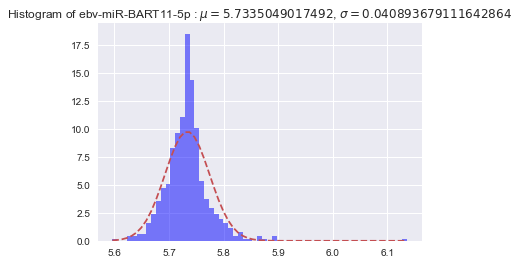

In [59]:
hist_col("ebv-miR-BART11-5p",miRNA,miRNA_description)

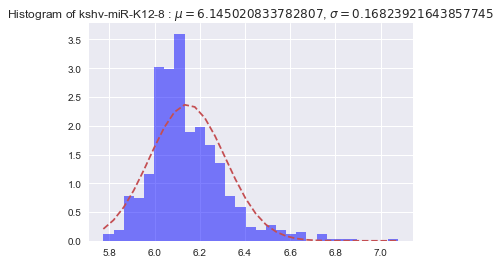

In [60]:
hist_col("kshv-miR-K12-8",miRNA,miRNA_description)

In [61]:
miRNA.size-np.isfinite(miRNA).sum().sum()

0

In [62]:
result=0
for each in miRNA.index.tolist():
    if each in mRNAArray.index.tolist():
        result=result+1
result

0

In [63]:
#miRNA targets were obtained from the R package: https://bioconductor.org/packages/release/bioc/vignettes/multiMiR/inst/doc/multiMiR.html#71_example_1:_retrieve_all_validated_target_genes_of_a_given_mirna
#using only experimentally validated interactions

In [64]:
a=pd.read_csv(folder_Firebrowse_GBM+"miRNA_targets_GBM_Firebrowse.csv",header=None, sep =",")
flat_list = [item for sublist in a.values.tolist() for item in sublist]
miRNA_targets=set(flat_list)

In [65]:
len(miRNA_targets)

341

In [66]:
#We found 341 different targets of the miRNA from the GBM Firebrowse dataset

In [67]:
ind=list(miRNA_targets)
ind=Verhaak.index.tolist()
miRNA_Verhaak=mRNAArray.loc[ind,col]
miRNA_Verhaak=miRNA_Verhaak.dropna(axis=1)


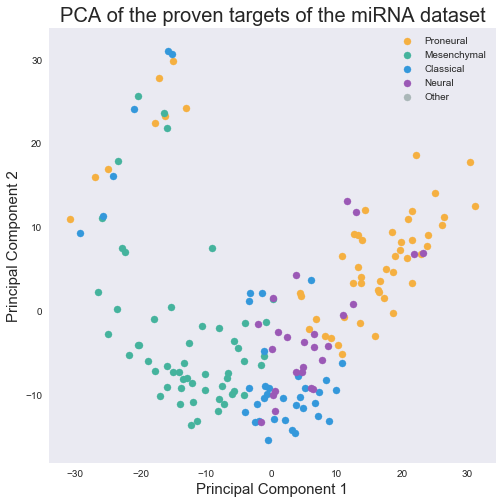

In [72]:
#Code to mark the samples in mRNAArray as one of the four subclasses of GBM or as other
result=list()
for i in miRNA_Verhaak.index.tolist():
    if i in labels["Hybridization REF"].tolist():
        index=labels["Hybridization REF"].tolist().index(i)
        result.append(labels.loc[index,"Subtype"])
    else:
        result.append("Other")
result=pd.DataFrame(result,columns=["target"])
result.head()

#Code to build the PCA plot
pca = decomposition.PCA(n_components=2)
PC = pca.fit_transform(miRNA_Verhaak.values)
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
targets=["Proneural","Mesenchymal","Classical","Neural","Other"]
colors = ["#F5B041", '#45B39D', '#3498DB',"#9B59B6","#AAB7B8"]
ax.set_title('PCA of the proven targets of the miRNA dataset', fontsize = 20)
for target,color in zip(targets,colors):
    indicesToKeep = result['target'] == target
    ax.scatter(PC[indicesToKeep,0]
               , PC[indicesToKeep,1]
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid() 

## Methylation

In [69]:
Methylation= pd.read_csv(folder_Firebrowse_GBM+'gdac.broadinstitute.org_GBM.Merge_methylation__humanmethylation27__jhu_usc_edu__Level_3__within_bioassay_data_set_function__data.Level_3.2016012800.0.0.csv', sep=",",header=0,index_col=0)
Methylation=Methylation.drop(columns=["Gene_Symbol","Chromosome","Genomic_Coordinate"])
Methylation=Methylation.transpose()
Methylation=Methylation.apply(pd.to_numeric)
Methylation.tail()

,cg00000292,cg00002426,cg00003994,cg00005847,cg00006414,cg00007981,cg00008493,cg00008713,cg00009407,cg00010193,cg00011459,cg00012199,cg00012386,cg00012792,cg00013618,cg00014085,cg00014837,cg00015770,cg00016968,cg00019495,cg00020533,cg00021527,cg00022606,cg00022866,cg00024396,cg00024812,cg00025138,cg00025991,cg00027083,cg00027674,cg00029826,cg00029931,cg00030047,cg00031162,cg00032227,cg00032666,cg00033516,cg00033773,cg00034039,cg00035347,cg00035623,cg00037763,cg00037940,cg00040861,cg00040873,cg00041575,cg00042156,cg00043004,cg00043080,cg00044245,cg00044729,cg00047050,cg00047469,cg00049986,cg00050312,cg00051623,cg00051979,cg00053292,cg00053647,cg00054706,cg00055233,cg00056767,cg00057593,cg00058938,cg00059225,cg00059424,cg00059740,cg00059930,cg00060762,cg00060882,cg00061059,cg00061629,cg00062776,cg00063144,cg00065385,cg00065408,cg00066153,cg00066816,cg00067471,cg00069261,cg00071250,cg00071998,cg00072216,cg00073650,cg00075967,cg00076645,cg00077457,cg00077877,cg00078194,cg00078867,cg00079056,cg00079563,cg00080012,cg00081935,cg00081975,cg00083720,cg00083937,cg00084687,cg00089071,cg00090147,cg00091693,cg00093177,cg00094319,cg00094851,cg00095526,cg00095674,cg00096922,cg00097536,cg00098162,cg00098239,cg00099550,cg00101227,cg00103783,cg00105253,cg00105470,cg00107187,cg00107488,cg00107632,cg00108454,cg00109274,cg00112517,cg00113020,cg00113951,cg00115714,cg00116234,cg00116838,cg00117172,cg00119079,cg00121158,cg00121640,cg00121904,cg00123035,cg00126034,cg00126657,cg00126698,cg00128197,cg00128560,cg00128654,cg00128766,cg00128877,cg00129774,cg00131121,cg00131557,cg00132141,cg00133909,cg00134539,cg00134787,cg00135056,cg00135393,cg00136105,cg00136405,cg00136477,cg00136736,cg00138126,cg00141162,cg00141550,cg00141845,cg00143376,cg00143998,cg00145118,cg00145348,cg00146096,cg00149659,cg00149976,cg00151234,cg00151607,cg00152644,cg00155167,cg00155485,cg00155609,cg00156216,cg00156744,cg00158308,cg00160914,cg00162401,cg00162643,cg00164041,cg00164898,cg00165981,cg00167504,cg00168082,cg00168785,cg00168942,cg00169548,cg00171126,cg00171161,cg00174500,cg00174901,cg00176210,cg00176879,cg00177013,cg00177698,cg00177923,cg00178790,cg00179446,cg00180012,cg00180631,cg00182461,cg00183782,cg00183916,cg00184884,cg00184893,cg00185103,cg00185839,cg00186141,cg00186701,cg00186954,cg00187380,cg00187686,cg00188348,cg00191052,cg00194146,cg00195561,cg00197381,cg00197641,cg00199549,cg00200063,cg00201234,cg00202702,cg00202711,cg00204262,cg00206052,cg00207534,cg00208830,cg00208967,cg00209066,cg00209951,cg00210842,cg00211661,cg00212549,cg00213044,cg00213331,cg00213714,cg00214346,cg00214794,cg00214855,cg00215066,cg00216361,cg00216758,cg00217795,cg00221494,cg00223186,cg00223950,cg00224234,cg00224508,cg00226904,cg00226923,cg00228799,cg00229387,cg00230271,...,cg27394046,cg27394486,cg27394563,cg27394566,cg27395450,cg27397287,cg27398499,cg27398547,cg27400772,cg27401095,cg27402949,cg27403635,cg27403822,cg27404050,cg27406727,cg27409012,cg27409364,cg27412093,cg27412902,cg27413025,cg27413508,cg27413543,cg27416067,cg27416437,cg27417997,cg27418851,cg27419217,cg27420123,cg27420236,cg27425193,cg27425675,cg27426707,cg27427207,cg27429194,cg27431150,cg27431247,cg27431396,cg27431859,cg27433062,cg27433088,cg27436184,cg27437944,cg27440002,cg27440834,cg27441551,cg27442349,cg27443050,cg27443224,cg27444994,cg27445265,cg27446185,cg27446233,cg27447599,cg27447740,cg27449489,cg27449959,cg27453644,cg27456885,cg27457941,cg27458888,cg27459381,cg27460755,cg27461196,cg27462160,cg27462371,cg27462398,cg27462969,cg27464755,cg27465531,cg27465566,cg27465569,cg27465849,cg27465858,cg27467734,cg27470406,cg27470554,cg27472032,cg27472295,cg27475152,cg27476329,cg27477205,cg27477594,cg27477990,cg27478651,cg27478659,cg27480700,cg27485235,cg27485921,cg27486427,cg27488807,cg27489994,cg27490193,cg27491887,cg27493997,cg27494383,cg27495845,cg27495908,cg27496506,cg27497687,cg27497781,cg27497900,cg27498304,cg27501380,cg27501458,cg27504117,cg27504299,cg27504805,cg27504991,cg27505538,cg27507704,cg27508002,cg27508071,cg27508821,cg

In [70]:
Methylation.shape

(285, 27578)

In [71]:
Methylation_description=Methylation.describe()
Methylation_description.head(10)

KeyboardInterrupt: 

In [ ]:
(Methylation.size-Methylation.isnull().sum().sum())/Methylation.size

In [68]:
#Many Columns entries are null! (710.000 aprox), which is 90% approx

## CopyNumber

In [73]:
#GISTIC:all_data_by_genes.txt output data. This data is a gene-level table of copy number values for all samples. 
#The returned copy number values are in units (copy number - 2) so that no amplification or deletion is 0, genes 
#with amplifications have positive values, and genes with deletions are negative values. The data are converted 
#from marker level to gene level using the extreme method: a gene is assigned the greatest amplification or the 
#least deletion value among the markers it covers. Results may be filtered by cohort, gene, or barcode, but at 
#least one gene or barcode must be supplied.
#Other datasets available are: Threshold(no amplification or deletion above a certain thershold) and Peaks

Genomic Identification of Significant Targets in Cancer (GISTIC), for identifying regions of aberration that are more likely to drive cancer pathogenesis. The method identifies those regions of the genome that are aberrant more often than would be expected by chance, with greater weight given to high-amplitude events (high-level copy-number gains or homozygous deletions) that are less likely to represent random aberrations.

In [134]:
CopyNumber= pd.read_csv(folder_Firebrowse_GBM+'GISTIC_AllByGene.csv', sep=",",header=0,index_col=1)
CopyNumber=CopyNumber.drop(columns=["Locus.ID","Cytoband","Unnamed: 0"])
CopyNumber.head()
CopyNumber=CopyNumber.transpose()
new_index=pd.Series([w.replace(".","-") for w in CopyNumber.index.tolist()])
CopyNumber.set_index(new_index,inplace=True)
CopyNumber=CopyNumber.apply(pd.to_numeric)
CopyNumber.index=CopyNumber.index.map(chop)
CopyNumber.head()

Gene.Symbol,ACAP3,ACTRT2,AGRN,ANKRD65,ATAD3A,ATAD3B,ATAD3C,AURKAIP1,B3GALT6,C1orf159,C1orf170,C1orf222,C1orf233,C1orf86,CALML6,CCNL2,CDK11A,CDK11B,CPSF3L,DDX11L1,DVL1,FAM132A,FAM138A,FAM213B,FAM41C,FAM87B,GABRD,GLTPD1,GNB1,HES4,HES5,ISG15,KLHL17,LINC00115,LINC00982,MIB2,MIR200A,MIR200B,MIR429,MMEL1,MMP23B,MORN1,MRPL20,MXRA8,NADK,NOC2L,OR4F16,OR4F29,OR4F5,PANK4,PEX10,PLCH2,PLEKHN1,PRDM16,PRKCZ,PUSL1,RER1,RN7SL657P,RNF223,SAMD11,SCNN1D,SDF4,SKI,SLC35E2B,SLC35E2,SSU72,TAS1R3,TMEM240,TMEM52,TMEM88B,TNFRSF14,TNFRSF18,TNFRSF4,TTC34,TTLL10,UBE2J2,VWA1,ARHGEF16,MEGF6,MIR551A,TPRG1L,WRAP73,TP73,CCDC27,SMIM1,LRRC47,RN7SL574P,CEP104,DFFB,C1orf174,AJAP1,MIR4417,MIR4689,NPHP4,KCNAB2,CHD5,RPL22,RNF207,ICMT,LINC00337,GPR153,HES3,ACOT7,HES2,ESPN,MIR4252,PLEKHG5,TNFRSF25,NOL9,TAS1R1,ZBTB48,KLHL21,PHF13,THAP3,DNAJC11,snoU13|ENSG00000239166.1,CAMTA1,VAMP3,PER3,UTS2,TNFRSF9,PARK7,ERRFI1,RN7SL729P,SLC45A1,RERE,SNORA77|ENSG00000221083.1,ENO1,CA6,RN7SL451P,SLC2A7,SLC2A5,SCARNA16|ENSG00000252404.1,GPR157,MIR34A,H6PD,SPSB1,RNA5SP40,SLC25A33,TMEM201,C1orf200,PIK3CD,CLSTN1,CTNNBIP1,LZIC,NMNAT1,RN7SKP269,MIR5697,RBP7,UBE4B,KIF1B,MIR1273D,RN7SL731P,RN7SL721P,PGD,APITD1,CORT,DFFA,PEX14,RN7SL614P,CASZ1,C1orf127,TARDBP,MASP2,SRM,EXOSC10,MTOR,snoU13|ENSG00000271794.1,ANGPTL7,UBIAD1,PTCHD2,FBXO2,FBXO44,FBXO6,MAD2L2,DRAXIN,AGTRAP,C1orf167,MTHFR,CLCN6,NPPA,NPPB,KIAA2013,PLOD1,MFN2,MIIP,RN7SL649P,TNFRSF8,TNFRSF1B,MIR4632,SNORA70|ENSG00000252969.1,VPS13D,SNORA59A,DHRS3,RNU6ATAC18P,AADACL4,AADACL3,snoU13|ENSG00000238771.1,C1orf158,HNRNPCL1,PRAMEF10,PRAMEF11,PRAMEF12,PRAMEF13,PRAMEF14,PRAMEF15,PRAMEF16,PRAMEF17,PRAMEF18,PRAMEF19,PRAMEF1,PRAMEF21,PRAMEF22,PRAMEF2,PRAMEF3,PRAMEF4,PRAMEF5,PRAMEF6,PRAMEF7,PRAMEF8,PRAMEF9,PRAMEF20,LRRC38,PDPN,RNA5SP41,SCARNA11|ENSG00000253085.1,PRDM2,KAZN,TMEM51,C1orf195,FHAD1,EFHD2,CTRC,CELA2A,CELA2B,CASP9,DNAJC16,SCARNA21|ENSG00000251866.1,AGMAT,DDI2,RSC1A1,PLEKHM2,FBLIM1,SLC25A34,TMEM82,SPEN,snoU13|ENSG00000238818.1,ZBTB17,C1orf64,HSPB7,...,MIR450B,MIR503HG,MIR542,MIR503,LINC00629,PLAC1,FAM122B,FAM122C,MOSPD1,SMIM10,FAM127C,FAM127A,FAM127B,LINC00087,LINC00633,CT45A1,CT45A2,CT45A3,CT45A4,CT45A5,CT45A6,CXorf48,DDX26B,LINC00086,RNA5SP515,SAGE1,ZNF449,ZNF75D,MMGT1,SLC9A6,snoU13|ENSG00000239080.1,FHL1,MAP7D3,GPR112,BRS3,HTATSF1,VGLL1,MIR934,LINC00892,CD40LG,ARHGEF6,RBMX,SNORD61|ENSG00000206979.1,GPR101,ZIC3,RN7SL325P,RN7SKP31,FGF13,MIR504,F9,MCF2,ATP11C,CXorf66,MIR505,RN7SL727P,RNU6ATAC23P,SNORA18|ENSG00000252719.1,snoU13|ENSG00000238485.1,SOX3,LINC00632,CDR1,MIR320D2,SPANXB1,SPANXB2,LDOC1,MAGEC1,MAGEC3,SPANXA1,SPANXA2,SPANXC,SPANXD,MAGEC2,RNA5SP516,snoU13|ENSG00000239188.1,SPANXN4,RN7SKP81,RN7SKP149,SPANXN3,SLITRK4,SPANXN2,UBE2NL,RN7SKP189,SPANXN1,SLITRK2,TMEM257,MIR888,MIR890,MIR892A,MIR892B,MIR891B,MIR891A,RNA5SP517,CXorf51A,CXorf51B,MIR513C,MIR513B,MIR513A1,MIR513A2,MIR506,MIR507,MIR508,MIR514B,MIR510,MIR514A1,MIR514A2,MIR514A3,FMR1,FMR1NB,AFF2,RN7SKP267,IDS,LINC00893,CXorf40A,CXorf40B,HSFX1,HSFX2,LINC00894,MAGEA11,MAGEA8,MAGEA9B,MAGEA9,TMEM185A,MIR2114,MAMLD1,MTM1,MTMR1,CD99L2,U3|ENSG00000253009.1,HMGB3,MIR4330,GPR50,VMA21,PASD1,PRRG3,FATE1,CNGA2,MAGEA4,GABRE,MIR224,MIR452,MAGEA10,GABRA3,MIR767,GABRQ,CETN2,CSAG1,CSAG2,CSAG3,CSAG4,MAGEA12,MAGEA1,MAGEA2B,MAGEA2,MAGEA3,MAGEA6,NSDHL,PNMA3,PNMA5,PNMA6A,PNMA6B,PNMA6C,PNMA6D,RN7SL190P,RN7SL667P,ZFP92,ZNF185,ZNF275,snoU13|ENSG00000239037.1,HAUS7,TREX2,BGN,ATP2B3,FAM58A,DUSP9,RN7SL687P,PNCK,SLC6A8,BCAP31,ABCD1,PLXNB3,IDH3G,SRPK3,SSR4,PDZD4,SNORD36|ENSG00000251846.1,L1CAM,LCA10,AVPR2,ARHGAP4,NAA10,HCFC1,RENBP,TMEM187,IRAK1,MECP2,MIR718,OPN1LW,OPN1MW2,OPN1MW,TEX28P1,TEX28P2,TEX28,TKTL1,EMD,FLNA,RPL10,SNORA70|ENSG00000207165.1,DNASE1L1,TAZ,ATP6AP1,FAM50A,GDI1,PLXNA3,LAGE3,UBL4A,SLC10A3,RN7SL697P,RN7SL742P,FAM3A,G6PD,IKBKG,BRCC3,CLIC2,CMC4,CTAG1A,CTAG1B,CTAG2,DKC1,F8A1,F8A2,F8A3,F8,FUNDC2,GAB3,H2AFB1,H2AFB2,H2AFB3,MPP1,MTCP1,RAB39B,SMIM9,SNORA36A,SNORA56,TMLHE,VBP1,IL9R|ENSG00000124334.12,SPRY3|ENSG00000168939.6,VAMP7|ENSG00000124333.10,WASH6P|ENSG00000182484.10,WASIR1|ENSG00000185203.7
TCGA-02-00

In [75]:
CopyNumber.shape

(577, 24776)

In [71]:
CopyNumber_description=CopyNumber.describe()
CopyNumber_description.head(10)

Gene.Symbol,ACAP3,ACTRT2,AGRN,ANKRD65,ATAD3A,ATAD3B,ATAD3C,AURKAIP1,B3GALT6,C1orf159,...,SMIM9,SNORA36A,SNORA56,TMLHE,VBP1,IL9R|ENSG00000124334.12,SPRY3|ENSG00000168939.6,VAMP7|ENSG00000124333.10,WASH6P|ENSG00000182484.10,WASIR1|ENSG00000185203.7
count,577.000000,577.000000,577.000000,577.000000,577.000000,577.000000,577.000000,577.000000,577.000000,577.000000,...,577.000000,577.000000,577.000000,577.000000,577.000000,577.000000,577.000000,577.000000,577.000000,577.000000
mean,-0.022818,-0.022818,-0.022818,-0.022818,-0.022818,-0.022818,-0.022818,-0.022818,-0.022818,-0.022818,...,-0.040938,-0.040938,-0.040938,-0.040938,-0.040938,-0.040938,-0.040938,-0.040938,-0.040938,-0.040938
std,0.294683,0.294683,0.294683,0.294683,0.294683,0.294683,0.294683,0.294683,0.294683,0.294683,...,0.168788,0.168788,0.168788,0.168788,0.168788,0.168788,0.168788,0.168788,0.168788,0.168788
min,-1.083000,-1.083000,-1.083000,-1.083000,-1.083000,-1.083000,-1.083000,-1.083000,-1.083000,-1.083000,...,-0.805000,-0.805000,-0.805000,-0.805000,-0.805000,-0.805000,-0.805000,-0.805000,-0.805000,-0.805000
25%,-0.035000,-0.035000,-0.035000,-0.035000,-0.035000,-0.035000,-0.035000,-0.035000,-0.035000,-0.035000,...,-0.089000,-0.089000,-0.089000,-0.089000,-0.089000,-0.089000,-0.089000,-0.089000,-0.089000,-0.089000
50%,0.003000,0.003000,0.003000,0.003000,0.003000,0.003000,0.003000,0.003000,0.003000,0.003000,...,-0.041000,-0.041000,-0.041000,-0.041000,-0.041000,-0.041000,-0.041000,-0.041000,-0.041000,-0.041000
75%,0.045000,0.045000,0.045000,0.045000,0.045000,0.045000,0.045000,0.045000,0.045000,0.045000,...,-0.001000,-0.001000,-0.001000,-0.001000,-0.001000,-0.001000,-0.001000,-0.001000,-0.001000,-0.001000
max,1.228000,1.228000,1.228000,1.228000,1.228000,1.228000,1.228000,1.228000,1.228000,1.228000,...,1.797000,1.797000,1.797000,1.797000,1.797000,1.797000,1.797000,1.797000,1.797000,1.797000


In [67]:
#It seems like none of the Verhaak samples are in this dataset

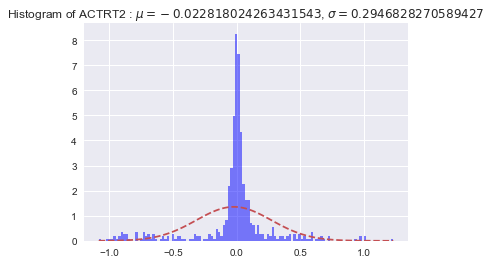

In [131]:
hist_col("ACTRT2",CopyNumber,CopyNumber_description)

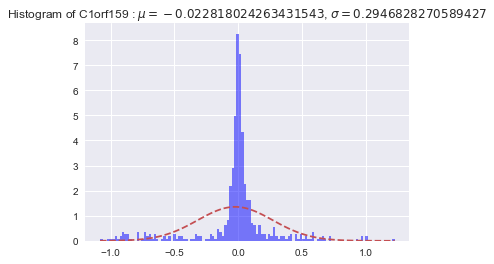

In [132]:
hist_col("C1orf159",CopyNumber,CopyNumber_description)

## RNASeq Data

In [68]:
#This data I couldn't obtain directly from RTCGA, so I downloaded it from here:http://firebrowse.org/?cohort=GBM

In [76]:
RNASeq.shape

NameError: name 'RNASeq' is not defined

In [ ]:
RNASeq=pd.read_csv(folder_Firebrowse_GBM+'GBM.rnaseqv2__illuminahiseq_rnaseqv2__unc_edu__Level_3__RSEM_genes_normalized__data.data.txt', sep="\t",header=0,index_col=0)
RNASeq=RNASeq.drop(index="gene_id")
RNASeq=RNASeq.apply(pd.to_numeric)
RNASeq=RNASeq.transpose()
RNASeq.head()

In [ ]:
RNASeq_description=RNASeq.describe()
RNASeq_description.head(9)

In [ ]:
hist_col("ZZZ3|26009",RNASeq,RNASeq_description)

In [ ]:
hist_col("tAKR|389932",RNASeq,RNASeq_description)

## Somatic mutation data

In [94]:
SomaticMutation=pd.read_csv(folder_Firebrowse_GBM+'Somatic_Mutation_GBM.maf.pct', sep="\t",header=0,index_col=0)
SomaticMutation.head()

,RNF17,REM1,REM2,PMM1,ASS1,FHIT,ZNF709,C6orf142,CAMK1,ZNF701,ZNF700,EN2,ZC3H13,RNF112,HMGCLL1,ZC3H18,PISD,DHX8,NUP98,XPC,SP1,GRINA,SP3,SP4,SP5,SP6,CAMKV,OR5B3,OPA3,RAB40A,COL7A1,GTSE1,OVCH1,SPPL2A,SPPL2B,MYO3A,ITGA9,MYO3B,ATP2A1,ATP2A3,ITGA1,ITGA2,NOP2,ITGA4,ITGA5,RIT1,ITGA7,TRHR,DENND4C,SWAP70,PHLDA1,PHLDA3,UFSP2,PAMR1,FBXL13,FBXL12,HRH2,HRH3,FBXL17,FBXL16,FBXL19,FBXL18,FAM116A,FAM169B,SDK1,SDK2,TPRN,THSD4,THSD1,COL4A6,COL4A5,COL4A4,COL4A3,COL4A2,COL4A1,OR8J3,CHST1,CHST2,CHST5,CHST4,CHST6,ITGAX,BCL2A1,ITGAV,HIBCH,ITGAM,HLF,NOV,ITGAD,ITGAE,FAM134A,TRERF1,LRPAP1,SMAD7,RIC3,SMAD3,MUS81,AMMECR1L,TMPRSS11A,IGF2R,TMPRSS11F,NECAP2,SLC36A3,SLC36A2,C14orf115,HYI,ZC3H15,ART1,ART5,ART4,RNF111,TCEA3,TCEA1,ABCD1,ABCD2,LAPTM4B,PIPOX,CADPS2,CCDC114,CCDC112,CCDC113,CCDC110,LEO1,ATP1A4,ATP1A3,ATP1A2,ATP1A1,MGRN1,SPHK2,DPT,IPO11,C2CD2,CPEB4,CPEB2,RBMXL1,RBMXL2,ZNF780A,ZNF780B,FRG1,SIRPA,IFT80,SARDH,NUP93,CREBL2,ATG4B,ATG4D,PHOX2B,NLRP14,KITLG,CFH,CFI,ANKFY1,C1orf14,CFB,OR5P2,MLLT4,CFP,AAAS,SIX4,SAGE1,VPS33A,CNPY4,NAALAD2,KNDC1,HMG20A,HMG20B,PHOSPHO2,CREB1,C3orf72,C3orf70,ZFP82,EFHA1,RFPL1,RFX4,RFX5,RFX6,RFX7,NRXN3,RFPL3,RFX2,RFX3,YDJC,FAM81B,APC,ETV3L,XPNPEP2,UQCRC1,ZNHIT3,PAPLN,ADNP,ZNF57,KHDRBS2,DCTN2,LHCGR,OR1Q1,GPR78,C11orf2,DPYSL5,DPYSL2,C11orf9,KRTAP10-12,KRTAP10-11,KRTAP10-10,IGFBP3,IGFBP1,HBE1,B4GALT2,CYP1B1,C15orf26,C15orf27,APLNR,GJA5,GJA8,CYP8B1,KDM3A,S1PR1,TMC4,TMC5,TMC6,TMC7,TMC1,TMC2,TMC3,TMC8,EIF2B1,PRKAR2B,MAGT1,C20orf54,TXNIP,TMEM14E,MECOM,ITGA2B,MYT1L,C9orf125,CFHR2,PHACTR4,CLIC4,CLIC5,L3MBTL,OR2K2,CFHR4,NLGN1,KIAA0020,RIT2,TMEM147,TMEM146,ASGR2,TMEM144,TMEM143,ITGA6,...,GBP7,MAN2A2,GBP5,GBP4,GRLF1,CORO2A,CCDC135,LCT,SPACA1,GALK2,SPACA3,OTOA,SLURP1,CCDC138,OR52I1,OTOF,STK31,STK35,STRC,PHF5A,AGTR1,NXNL2,LCK,GGNBP2,SYN1,ACCSL,THEG,PAPD5,C12orf12,CD5,CD6,CD7,CD2,AMN1,STAT6,APH1A,LAMC1,STAT3,STAT2,STAT1,FAM54B,FAM54A,CHRNB2,CHRNB4,CYP7A1,HSDL2,POLE2,HTATSF1,GABRB1,GABRB2,GABRB3,BTAF1,PODNL1,CDA,PLXNA3,PLXNA2,PLXNA1,ASNS,PLXNA4,PLG,PDE4A,PDE4B,PDE4C,PEG3,SCAI,RPL7,MRPS25,MAP2K3,BMPR1B,MAP2K7,NLRC4,SCAP,ADCYAP1R1,TSPAN9,NR1H3,TPRG1,ACY3,MALT1,PHF8,COL18A1,OR4P4,PPP2R5D,SUCLG1,OPRK1,GRPR,ALDOB,BAZ1A,PHF3,ABCC8,ABCC9,ABCC4,HAO1,HAO2,GPR176,COL20A1,TPR,DNAH17,DNAH10,DNAH11,TMOD3,TMOD2,ZNF79,APLP1,APLP2,ZNF71,ZNF76,ZNF77,RPL22L1,GLI2,RYR1,RYR3,RYR2,TBC1D22A,GOLGA1,GOLGA2,GOLGA3,GOLGA4,EGR1,SLCO3A1,AQP12A,KIAA1244,ENPP6,ENPP7,ENPP4,ENPP5,ENPP2,KIF26B,ENPP1,LELP1,BTN3A3,T,GIPC1,GIPC2,ELFN2,CIRH1A,FZR1,HBG2,CD2AP,CFHR5,DKKL1,KDM5D,TP53I13,CPS1,KDM5B,KDM5C,AIPL1,KCNA6,GLUL,OR56A4,DNM1,DNM2,TGFA,PREX2,PREX1,ZNF287,IFT122,ZNF285,ZNF282,ZNF283,AGXT2L1,OR2B11,SLC14A2,SLC14A1,GYS2,EVPL,ACAP3,STRN3,ETV5,ETV4,BTBD9,FAM5B,FAM5C,BTBD3,CFL2,SULT1B1,TUBA8,RAD23B,MESDC1,HRNR,NOM1,IKZF1,IKZF3,STON2,IL4I1,PLEKHG2,SPATS2,NFIB,ADAMTS13,SLC13A3,SLC13A4,SLC13A5,RGS14,RGS12,PSPH,GPR1,EXOSC8,ERN1,LANCL3,PHF20L1,HMX3,UTP3,CLEC16A,VCAN,SLC33A1,CCAR1,ANKAR,BTN2A2,SLC7A13,ELF5,ELF4,ZRSR2,PRPS2,CAND2,CAND1,CDR1,NDN,BRPF3,TTLL11,TTLL10,TTLL13,TTLL12,GMPR2,ODF2L,ACAP1,ACAP2,PLAT,LUZP4,C1orf198,OR10J1,LUZP2,OR10J3,C8orf84,NFIC,PLEKHG3,NFIA,PLEKHG1,PLEKHG6,PLEKHG7,PLEKHG4,PLEKHG5,SLC7A14,SELE,SLC7A10,SLC7A11,SIGLEC1,GNGT2,SELT,BCL6B,NFIX,SELP
patient,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
GBM-06-6698-Tumor,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [95]:
SomaticMutation.tail()

,RNF17,REM1,REM2,PMM1,ASS1,FHIT,ZNF709,C6orf142,CAMK1,ZNF701,ZNF700,EN2,ZC3H13,RNF112,HMGCLL1,ZC3H18,PISD,DHX8,NUP98,XPC,SP1,GRINA,SP3,SP4,SP5,SP6,CAMKV,OR5B3,OPA3,RAB40A,COL7A1,GTSE1,OVCH1,SPPL2A,SPPL2B,MYO3A,ITGA9,MYO3B,ATP2A1,ATP2A3,ITGA1,ITGA2,NOP2,ITGA4,ITGA5,RIT1,ITGA7,TRHR,DENND4C,SWAP70,PHLDA1,PHLDA3,UFSP2,PAMR1,FBXL13,FBXL12,HRH2,HRH3,FBXL17,FBXL16,FBXL19,FBXL18,FAM116A,FAM169B,SDK1,SDK2,TPRN,THSD4,THSD1,COL4A6,COL4A5,COL4A4,COL4A3,COL4A2,COL4A1,OR8J3,CHST1,CHST2,CHST5,CHST4,CHST6,ITGAX,BCL2A1,ITGAV,HIBCH,ITGAM,HLF,NOV,ITGAD,ITGAE,FAM134A,TRERF1,LRPAP1,SMAD7,RIC3,SMAD3,MUS81,AMMECR1L,TMPRSS11A,IGF2R,TMPRSS11F,NECAP2,SLC36A3,SLC36A2,C14orf115,HYI,ZC3H15,ART1,ART5,ART4,RNF111,TCEA3,TCEA1,ABCD1,ABCD2,LAPTM4B,PIPOX,CADPS2,CCDC114,CCDC112,CCDC113,CCDC110,LEO1,ATP1A4,ATP1A3,ATP1A2,ATP1A1,MGRN1,SPHK2,DPT,IPO11,C2CD2,CPEB4,CPEB2,RBMXL1,RBMXL2,ZNF780A,ZNF780B,FRG1,SIRPA,IFT80,SARDH,NUP93,CREBL2,ATG4B,ATG4D,PHOX2B,NLRP14,KITLG,CFH,CFI,ANKFY1,C1orf14,CFB,OR5P2,MLLT4,CFP,AAAS,SIX4,SAGE1,VPS33A,CNPY4,NAALAD2,KNDC1,HMG20A,HMG20B,PHOSPHO2,CREB1,C3orf72,C3orf70,ZFP82,EFHA1,RFPL1,RFX4,RFX5,RFX6,RFX7,NRXN3,RFPL3,RFX2,RFX3,YDJC,FAM81B,APC,ETV3L,XPNPEP2,UQCRC1,ZNHIT3,PAPLN,ADNP,ZNF57,KHDRBS2,DCTN2,LHCGR,OR1Q1,GPR78,C11orf2,DPYSL5,DPYSL2,C11orf9,KRTAP10-12,KRTAP10-11,KRTAP10-10,IGFBP3,IGFBP1,HBE1,B4GALT2,CYP1B1,C15orf26,C15orf27,APLNR,GJA5,GJA8,CYP8B1,KDM3A,S1PR1,TMC4,TMC5,TMC6,TMC7,TMC1,TMC2,TMC3,TMC8,EIF2B1,PRKAR2B,MAGT1,C20orf54,TXNIP,TMEM14E,MECOM,ITGA2B,MYT1L,C9orf125,CFHR2,PHACTR4,CLIC4,CLIC5,L3MBTL,OR2K2,CFHR4,NLGN1,KIAA0020,RIT2,TMEM147,TMEM146,ASGR2,TMEM144,TMEM143,ITGA6,...,GBP7,MAN2A2,GBP5,GBP4,GRLF1,CORO2A,CCDC135,LCT,SPACA1,GALK2,SPACA3,OTOA,SLURP1,CCDC138,OR52I1,OTOF,STK31,STK35,STRC,PHF5A,AGTR1,NXNL2,LCK,GGNBP2,SYN1,ACCSL,THEG,PAPD5,C12orf12,CD5,CD6,CD7,CD2,AMN1,STAT6,APH1A,LAMC1,STAT3,STAT2,STAT1,FAM54B,FAM54A,CHRNB2,CHRNB4,CYP7A1,HSDL2,POLE2,HTATSF1,GABRB1,GABRB2,GABRB3,BTAF1,PODNL1,CDA,PLXNA3,PLXNA2,PLXNA1,ASNS,PLXNA4,PLG,PDE4A,PDE4B,PDE4C,PEG3,SCAI,RPL7,MRPS25,MAP2K3,BMPR1B,MAP2K7,NLRC4,SCAP,ADCYAP1R1,TSPAN9,NR1H3,TPRG1,ACY3,MALT1,PHF8,COL18A1,OR4P4,PPP2R5D,SUCLG1,OPRK1,GRPR,ALDOB,BAZ1A,PHF3,ABCC8,ABCC9,ABCC4,HAO1,HAO2,GPR176,COL20A1,TPR,DNAH17,DNAH10,DNAH11,TMOD3,TMOD2,ZNF79,APLP1,APLP2,ZNF71,ZNF76,ZNF77,RPL22L1,GLI2,RYR1,RYR3,RYR2,TBC1D22A,GOLGA1,GOLGA2,GOLGA3,GOLGA4,EGR1,SLCO3A1,AQP12A,KIAA1244,ENPP6,ENPP7,ENPP4,ENPP5,ENPP2,KIF26B,ENPP1,LELP1,BTN3A3,T,GIPC1,GIPC2,ELFN2,CIRH1A,FZR1,HBG2,CD2AP,CFHR5,DKKL1,KDM5D,TP53I13,CPS1,KDM5B,KDM5C,AIPL1,KCNA6,GLUL,OR56A4,DNM1,DNM2,TGFA,PREX2,PREX1,ZNF287,IFT122,ZNF285,ZNF282,ZNF283,AGXT2L1,OR2B11,SLC14A2,SLC14A1,GYS2,EVPL,ACAP3,STRN3,ETV5,ETV4,BTBD9,FAM5B,FAM5C,BTBD3,CFL2,SULT1B1,TUBA8,RAD23B,MESDC1,HRNR,NOM1,IKZF1,IKZF3,STON2,IL4I1,PLEKHG2,SPATS2,NFIB,ADAMTS13,SLC13A3,SLC13A4,SLC13A5,RGS14,RGS12,PSPH,GPR1,EXOSC8,ERN1,LANCL3,PHF20L1,HMX3,UTP3,CLEC16A,VCAN,SLC33A1,CCAR1,ANKAR,BTN2A2,SLC7A13,ELF5,ELF4,ZRSR2,PRPS2,CAND2,CAND1,CDR1,NDN,BRPF3,TTLL11,TTLL10,TTLL13,TTLL12,GMPR2,ODF2L,ACAP1,ACAP2,PLAT,LUZP4,C1orf198,OR10J1,LUZP2,OR10J3,C8orf84,NFIC,PLEKHG3,NFIA,PLEKHG1,PLEKHG6,PLEKHG7,PLEKHG4,PLEKHG5,SLC7A14,SELE,SLC7A10,SLC7A11,SIGLEC1,GNGT2,SELT,BCL6B,NFIX,SELP
patient,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
GBM-06-2563-Tumor,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [96]:
SomaticMutation_description=SomaticMutation.describe()
SomaticMutation_description.head(10)

,RNF17,REM1,REM2,PMM1,ASS1,FHIT,ZNF709,C6orf142,CAMK1,ZNF701,ZNF700,EN2,ZC3H13,RNF112,HMGCLL1,ZC3H18,PISD,DHX8,NUP98,XPC,SP1,GRINA,SP3,SP4,SP5,SP6,CAMKV,OR5B3,OPA3,RAB40A,COL7A1,GTSE1,OVCH1,SPPL2A,SPPL2B,MYO3A,ITGA9,MYO3B,ATP2A1,ATP2A3,ITGA1,ITGA2,NOP2,ITGA4,ITGA5,RIT1,ITGA7,TRHR,DENND4C,SWAP70,PHLDA1,PHLDA3,UFSP2,PAMR1,FBXL13,FBXL12,HRH2,HRH3,FBXL17,FBXL16,FBXL19,FBXL18,FAM116A,FAM169B,SDK1,SDK2,TPRN,THSD4,THSD1,COL4A6,COL4A5,COL4A4,COL4A3,COL4A2,COL4A1,OR8J3,CHST1,CHST2,CHST5,CHST4,CHST6,ITGAX,BCL2A1,ITGAV,HIBCH,ITGAM,HLF,NOV,ITGAD,ITGAE,FAM134A,TRERF1,LRPAP1,SMAD7,RIC3,SMAD3,MUS81,AMMECR1L,TMPRSS11A,IGF2R,TMPRSS11F,NECAP2,SLC36A3,SLC36A2,C14orf115,HYI,ZC3H15,ART1,ART5,ART4,RNF111,TCEA3,TCEA1,ABCD1,ABCD2,LAPTM4B,PIPOX,CADPS2,CCDC114,CCDC112,CCDC113,CCDC110,LEO1,ATP1A4,ATP1A3,ATP1A2,ATP1A1,MGRN1,SPHK2,DPT,IPO11,C2CD2,CPEB4,CPEB2,RBMXL1,RBMXL2,ZNF780A,ZNF780B,FRG1,SIRPA,IFT80,SARDH,NUP93,CREBL2,ATG4B,ATG4D,PHOX2B,NLRP14,KITLG,CFH,CFI,ANKFY1,C1orf14,CFB,OR5P2,MLLT4,CFP,AAAS,SIX4,SAGE1,VPS33A,CNPY4,NAALAD2,KNDC1,HMG20A,HMG20B,PHOSPHO2,CREB1,C3orf72,C3orf70,ZFP82,EFHA1,RFPL1,RFX4,RFX5,RFX6,RFX7,NRXN3,RFPL3,RFX2,RFX3,YDJC,FAM81B,APC,ETV3L,XPNPEP2,UQCRC1,ZNHIT3,PAPLN,ADNP,ZNF57,KHDRBS2,DCTN2,LHCGR,OR1Q1,GPR78,C11orf2,DPYSL5,DPYSL2,C11orf9,KRTAP10-12,KRTAP10-11,KRTAP10-10,IGFBP3,IGFBP1,HBE1,B4GALT2,CYP1B1,C15orf26,C15orf27,APLNR,GJA5,GJA8,CYP8B1,KDM3A,S1PR1,TMC4,TMC5,TMC6,TMC7,TMC1,TMC2,TMC3,TMC8,EIF2B1,PRKAR2B,MAGT1,C20orf54,TXNIP,TMEM14E,MECOM,ITGA2B,MYT1L,C9orf125,CFHR2,PHACTR4,CLIC4,CLIC5,L3MBTL,OR2K2,CFHR4,NLGN1,KIAA0020,RIT2,TMEM147,TMEM146,ASGR2,TMEM144,TMEM143,ITGA6,...,GBP7,MAN2A2,GBP5,GBP4,GRLF1,CORO2A,CCDC135,LCT,SPACA1,GALK2,SPACA3,OTOA,SLURP1,CCDC138,OR52I1,OTOF,STK31,STK35,STRC,PHF5A,AGTR1,NXNL2,LCK,GGNBP2,SYN1,ACCSL,THEG,PAPD5,C12orf12,CD5,CD6,CD7,CD2,AMN1,STAT6,APH1A,LAMC1,STAT3,STAT2,STAT1,FAM54B,FAM54A,CHRNB2,CHRNB4,CYP7A1,HSDL2,POLE2,HTATSF1,GABRB1,GABRB2,GABRB3,BTAF1,PODNL1,CDA,PLXNA3,PLXNA2,PLXNA1,ASNS,PLXNA4,PLG,PDE4A,PDE4B,PDE4C,PEG3,SCAI,RPL7,MRPS25,MAP2K3,BMPR1B,MAP2K7,NLRC4,SCAP,ADCYAP1R1,TSPAN9,NR1H3,TPRG1,ACY3,MALT1,PHF8,COL18A1,OR4P4,PPP2R5D,SUCLG1,OPRK1,GRPR,ALDOB,BAZ1A,PHF3,ABCC8,ABCC9,ABCC4,HAO1,HAO2,GPR176,COL20A1,TPR,DNAH17,DNAH10,DNAH11,TMOD3,TMOD2,ZNF79,APLP1,APLP2,ZNF71,ZNF76,ZNF77,RPL22L1,GLI2,RYR1,RYR3,RYR2,TBC1D22A,GOLGA1,GOLGA2,GOLGA3,GOLGA4,EGR1,SLCO3A1,AQP12A,KIAA1244,ENPP6,ENPP7,ENPP4,ENPP5,ENPP2,KIF26B,ENPP1,LELP1,BTN3A3,T,GIPC1,GIPC2,ELFN2,CIRH1A,FZR1,HBG2,CD2AP,CFHR5,DKKL1,KDM5D,TP53I13,CPS1,KDM5B,KDM5C,AIPL1,KCNA6,GLUL,OR56A4,DNM1,DNM2,TGFA,PREX2,PREX1,ZNF287,IFT122,ZNF285,ZNF282,ZNF283,AGXT2L1,OR2B11,SLC14A2,SLC14A1,GYS2,EVPL,ACAP3,STRN3,ETV5,ETV4,BTBD9,FAM5B,FAM5C,BTBD3,CFL2,SULT1B1,TUBA8,RAD23B,MESDC1,HRNR,NOM1,IKZF1,IKZF3,STON2,IL4I1,PLEKHG2,SPATS2,NFIB,ADAMTS13,SLC13A3,SLC13A4,SLC13A5,RGS14,RGS12,PSPH,GPR1,EXOSC8,ERN1,LANCL3,PHF20L1,HMX3,UTP3,CLEC16A,VCAN,SLC33A1,CCAR1,ANKAR,BTN2A2,SLC7A13,ELF5,ELF4,ZRSR2,PRPS2,CAND2,CAND1,CDR1,NDN,BRPF3,TTLL11,TTLL10,TTLL13,TTLL12,GMPR2,ODF2L,ACAP1,ACAP2,PLAT,LUZP4,C1orf198,OR10J1,LUZP2,OR10J3,C8orf84,NFIC,PLEKHG3,NFIA,PLEKHG1,PLEKHG6,PLEKHG7,PLEKHG4,PLEKHG5,SLC7A14,SELE,SLC7A10,SLC7A11,SIGLEC1,GNGT2,SELT,BCL6B,NFIX,SELP
count,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000

In [97]:
SomaticMutation.shape

(291, 9539)

# Selection of the training and testing datasets for the SBC model

In [98]:
#How many patients do we have CopyNumber, mRNAArray and miRNA

We have 577 patients with CopyNumber data, 575 patients with miRNA data and 538 patients with mRNAArray data.

In [101]:
ela=dict()
cat=dict()
for label in clinical.index:
    ela[label]=[]
    cat[label]=[]

for j in clinical.index.tolist():
    track=False
    for i in miRNA.index.tolist():
        if j in i:
            ela[j].append(i)
            track=True
    if track==True:
        cat[j].append(1)
    else:
        cat[j].append(0)
    
for j in clinical.index.tolist():
    track=False
    for i in mRNAArray.index.tolist():
        if j in i:
            ela[j].append(i)
            track=True
    if track==True:
        cat[j].append(1)
    else:
        cat[j].append(0)
            
for j in clinical.index.tolist():
    track=False
    for i in CopyNumber.index.tolist():
        if j in i:
            ela[j].append(i)
            track=True
    if track==True:
        cat[j].append(1)
    else:
        cat[j].append(0)
        
for j in clinical.index.tolist():
    track=False
    for i in SomaticMutation.index.tolist():
        if j[5:] in i:
            ela[j].append(i)
            track=True
    if track==True:
        cat[j].append(1)
    else:
        cat[j].append(0)

In [102]:
ela

{'TCGA-02-0001': ['TCGA-02-0001-01C-01T-0179-07',
  'TCGA-02-0001-01C-01R-0177-01',
  'TCGA-02-0001-01C-01D-0182-01'],
 'TCGA-02-0003': ['TCGA-02-0003-01A-01T-0179-07',
  'TCGA-02-0003-01A-01R-0177-01',
  'TCGA-02-0003-01A-01D-0182-01',
  'GBM-02-0003-Tumor'],
 'TCGA-02-0004': ['TCGA-02-0004-01A-01T-0301-07',
  'TCGA-02-0004-01A-01R-0298-01'],
 'TCGA-02-0006': ['TCGA-02-0006-01B-01T-0179-07',
  'TCGA-02-0006-01B-01D-0182-01'],
 'TCGA-02-0007': ['TCGA-02-0007-01A-01T-0179-07',
  'TCGA-02-0007-01A-01R-0177-01',
  'TCGA-02-0007-01A-01D-0182-01'],
 'TCGA-02-0009': ['TCGA-02-0009-01A-01T-0179-07',
  'TCGA-02-0009-01A-01R-0177-01',
  'TCGA-02-0009-01A-01D-0182-01'],
 'TCGA-02-0010': ['TCGA-02-0010-01A-01T-0179-07',
  'TCGA-02-0010-01A-01R-0177-01',
  'TCGA-02-0010-01A-01D-0182-01'],
 'TCGA-02-0011': ['TCGA-02-0011-01B-01T-0179-07',
  'TCGA-02-0011-01B-01R-0177-01',
  'TCGA-02-0011-01B-01D-0182-01'],
 'TCGA-02-0014': ['TCGA-02-0014-01A-01T-0179-07',
  'TCGA-02-0014-01A-01R-0177-01',
  'TCGA-0

In [103]:
result=list()
for each in ela.keys():
    if len(ela[each])==2 and each not in result:
        result.append(each)
len(result)

30

In [104]:
Final_dataset=pd.DataFrame.from_dict(cat, orient='index',columns=['miRNA', 'mRNAArray', 'CopyNumber', 'SomaticMutation'])
Final_dataset["Total"]=Final_dataset.sum(axis=1)
Final_dataset.head()

,miRNA,mRNAArray,CopyNumber,SomaticMutation,Total
TCGA-06-6391,1,1,1,1,4
TCGA-19-A6J4,0,0,1,0,1
TCGA-06-1806,1,0,1,1,3
TCGA-06-5408,1,1,1,1,4
TCGA-06-5410,1,1,1,1,4


In [105]:
#We have 517 patients with both miRNA and mRNAArray data

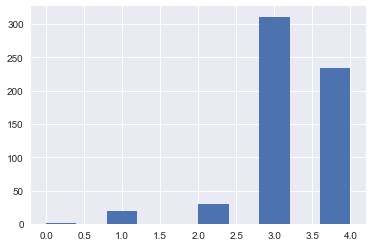

In [106]:
Final_dataset["Total"].hist()

In [107]:
howmany=0
for i in Verhaak_id:
    for j in SomaticMutation.index.tolist():
        if i[5:11] in j[4:10]:
            howmany=howmany+1

In [108]:
#274 patients from the Verhaak sample have somatic mutation data

In [109]:
howmany

274

In [110]:
Final_dataset=Final_dataset.join(Sample_status,how="left")
Final_dataset.tail()

,miRNA,mRNAArray,CopyNumber,SomaticMutation,Total,Subtype,vital_status,days_to_death
TCGA-76-6283,1,0,1,1,3,NaN,NaN,NaN
TCGA-76-6660,1,0,1,1,3,NaN,NaN,NaN
TCGA-81-5910,1,1,1,1,4,NaN,NaN,NaN
TCGA-81-5911,1,0,1,1,3,NaN,NaN,NaN
TCGA-87-5896,1,1,1,1,4,NaN,NaN,NaN


In [111]:
#Training Dataset
#Part of the Verhaak + mRNA + miRNA

In [150]:
Training_set=Final_dataset[(Final_dataset.miRNA==1)&(Final_dataset.mRNAArray==1)&(Final_dataset.CopyNumber==1)&(Final_dataset.Subtype)]
Training_set

,miRNA,mRNAArray,CopyNumber,SomaticMutation,Total,Subtype,vital_status,days_to_death
TCGA-02-0003,1,1,1,1,4,Proneural,1.0,144.0
TCGA-02-0007,1,1,1,0,3,Classical,1.0,705.0
TCGA-02-0009,1,1,1,0,3,Classical,1.0,322.0
TCGA-02-0010,1,1,1,0,3,Proneural,1.0,1077.0
TCGA-02-0011,1,1,1,0,3,Proneural,1.0,630.0
TCGA-02-0014,1,1,1,0,3,Proneural,1.0,2512.0
TCGA-02-0016,1,1,1,0,3,Classical,1.0,2648.0
TCGA-02-0021,1,1,1,0,3,Classical,1.0,2362.0
TCGA-02-0023,1,1,1,0,3,Classical,1.0,612.0
TCGA-02-0024,1,1,1,0,3,Proneural,1.0,1615.0


In [151]:
Training_set.shape

(160, 8)

In [158]:
mRNAArray.loc[Training_set.index.tolist()].to_csv(folder_TrainingSet+"mRNAArray_TrainingSet.csv")

In [159]:
miRNA.loc[Training_set.index.tolist()].to_csv(folder_TrainingSet+"miRNA_TrainingSet.csv")

In [160]:
CopyNumber.loc[Training_set.index.tolist()].to_csv(folder_TrainingSet+"CopyNumber_TrainingSet.csv")

In [169]:
clinical.loc[Training_set.index.tolist()].to_csv(folder_TrainingSet+"Clinical_TrainingSet.csv")

TRAINING SET SIZE= 160

In [168]:
TestSet=Final_dataset[(Final_dataset.miRNA==1)&(Final_dataset.mRNAArray==1)&(Final_dataset.CopyNumber==1)&(Final_dataset.Subtype.isnull())]
TestSet

,miRNA,mRNAArray,CopyNumber,SomaticMutation,Total,Subtype,vital_status,days_to_death
TCGA-06-6391,1,1,1,1,4,NaN,NaN,NaN
TCGA-06-5408,1,1,1,1,4,NaN,NaN,NaN
TCGA-06-5410,1,1,1,1,4,NaN,NaN,NaN
TCGA-06-5411,1,1,1,1,4,NaN,NaN,NaN
TCGA-06-5412,1,1,1,1,4,NaN,NaN,NaN
TCGA-06-5413,1,1,1,1,4,NaN,NaN,NaN
TCGA-06-5414,1,1,1,1,4,NaN,NaN,NaN
TCGA-06-5415,1,1,1,1,4,NaN,NaN,NaN
TCGA-06-5416,1,1,1,0,3,NaN,NaN,NaN
TCGA-06-5418,1,1,1,1,4,NaN,NaN,NaN


In [172]:
mRNAArray.loc[TestSet.index.tolist()].to_csv(folder_TestSet+"mRNAArray_TestSet.csv")

miRNA.loc[TestSet.index.tolist()].to_csv(folder_TestSet+"miRNA_TestSet.csv")

CopyNumber.loc[TestSet.index.tolist()].to_csv(folder_TestSet+"CopyNumber_TestSet.csv")

clinical.loc[TestSet.index.tolist()].to_csv(folder_TestSet+"Clinical_TestSet.csv")

In [173]:
TestSet.shape

(338, 8)